In [1]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import skimage
import skimage.measure
import matplotlib.patches as mpatches

from scipy import ndimage
from skimage import morphology, util, filters

import tifffile


# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

### Load image stack

In [2]:
# load tiff stake with pims. Notice here I only have two channels, gfp and cy5
#Burst /Volumes/SL_2023/0313/droplet_different_low_MT_6_8_2_burst

frames = pims.ImageSequence('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local to global pre-print/data/fig_4/cell_eater_1/Pos0/*.tif')
video = pims.Video('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local to global pre-print/manuscript and figures/figure_4/image_slices/cell_eater_bf.avi')

Frame([[760, 747, 865, ..., 886, 774, 764],
       [730, 844, 810, ..., 791, 771, 815],
       [802, 794, 726, ..., 856, 798, 677],
       ...,
       [709, 645, 700, ..., 719, 681, 696],
       [722, 620, 738, ..., 726, 639, 732],
       [676, 660, 596, ..., 731, 720, 775]], dtype=uint16)
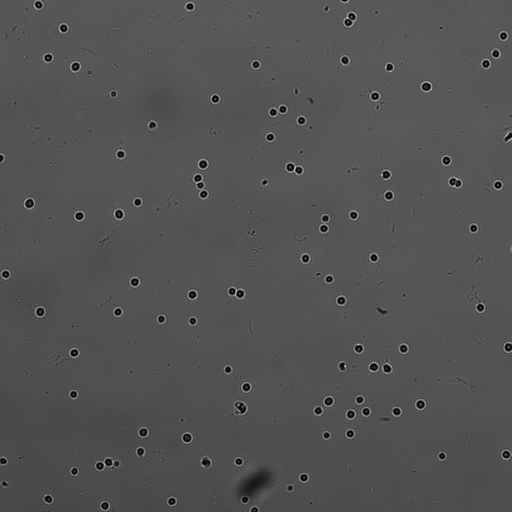

In [3]:
# only want the bf frame
bf_frames = frames[::3]
bf_frames[1]

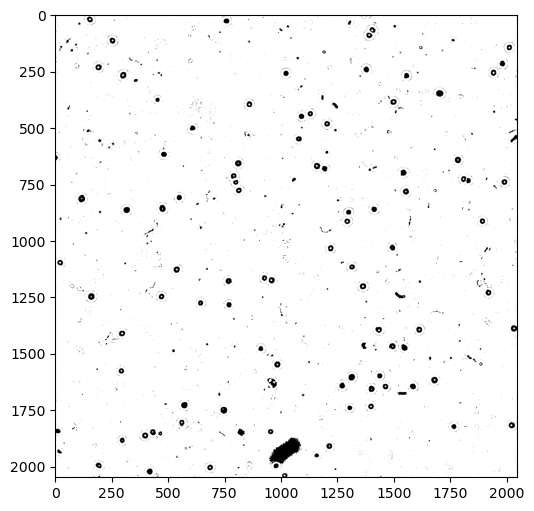

In [4]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,301)
    idx = img < adaptive_thresh
    idx2 = img > adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[1]);

Found 5418 features


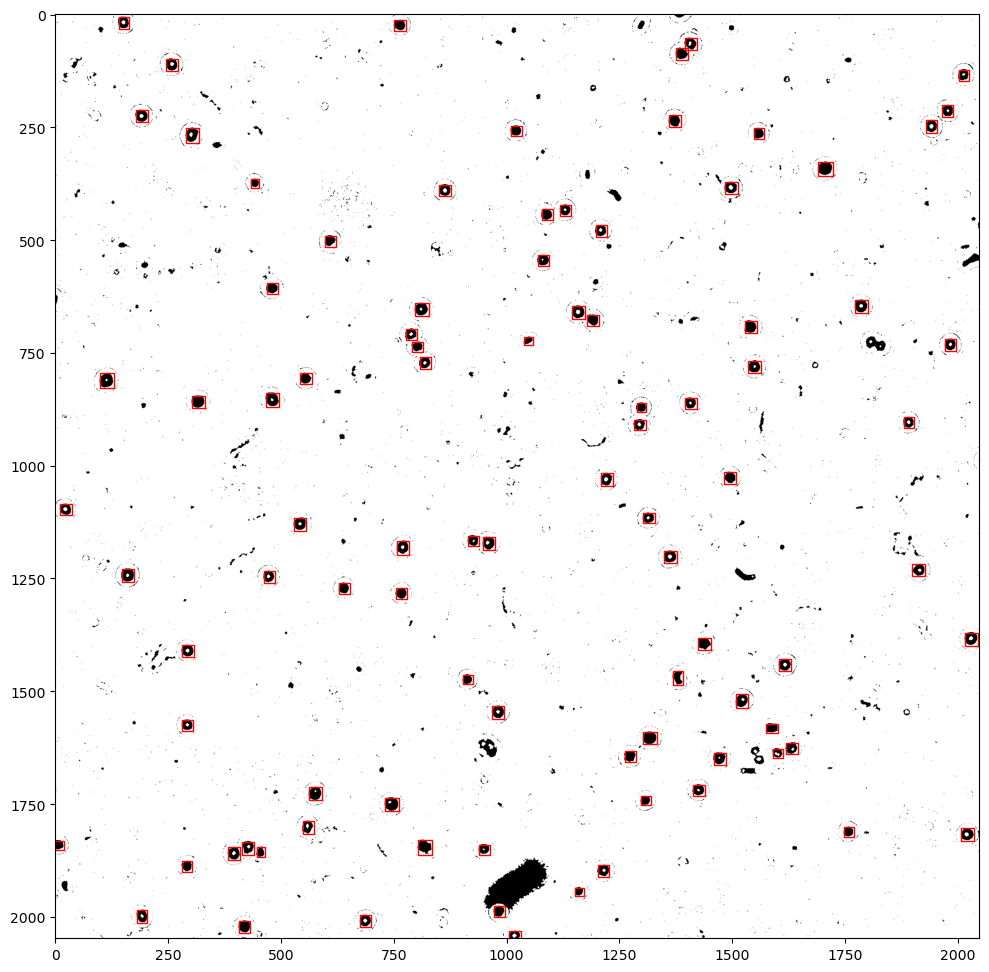

In [5]:
img_example = frames_thresh[24]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 200 or region.area > 1000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 1000 and region.area < 200:
        continue
    # Skip non-rounded features using eccentricity
    max_eccentricity = 0.8  # Adjust this threshold as needed
    if region.eccentricity > max_eccentricity:
        continue

    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [6]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            200 <= region.area <= 1000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 1000 and region.area < 200) and
            region.eccentricity <= 0.8
        )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


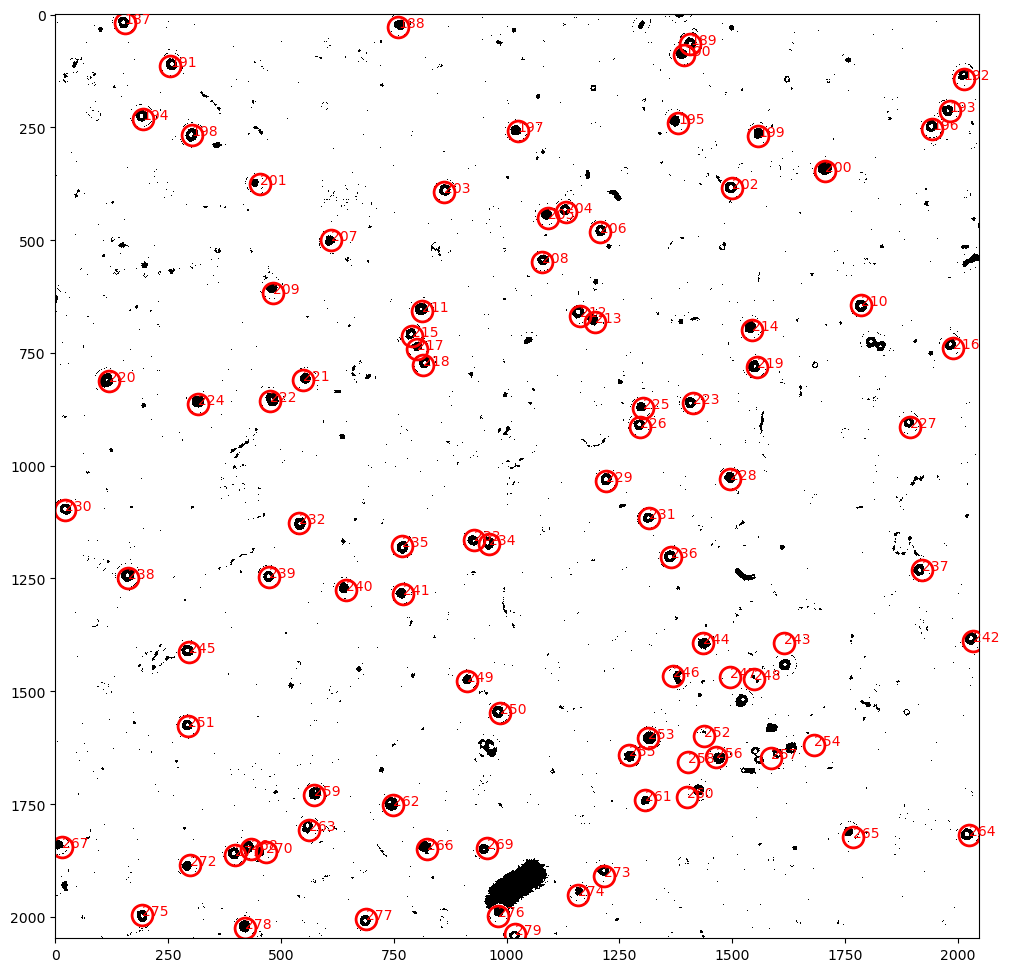

In [7]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(id_example+1, features, img_example)


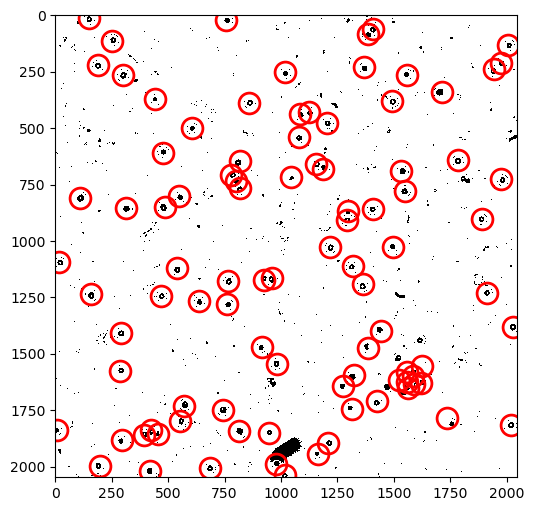

In [8]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 324: 73 trajectories present.


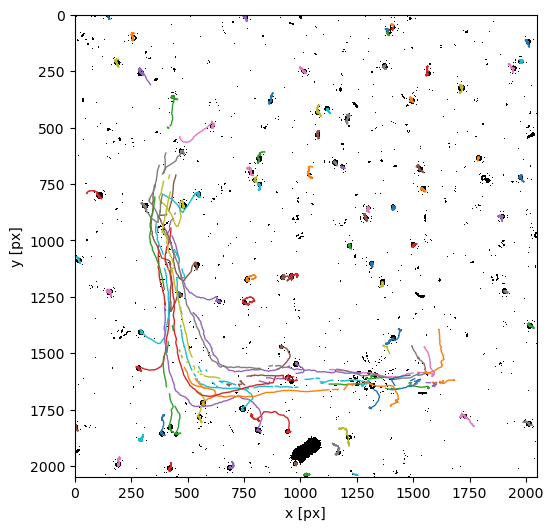

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [54]:
search_range = 50
t = tp.link_df(features, search_range, memory=20)
t1 = tp.filter_stubs(t, threshold=50)

tp.plot_traj(t1, superimpose=frames_thresh[100])

In [10]:
t1

y            x  frame  particle
frame                                           
0        18.708609   155.448124      0         0
0      1604.218845  1314.664134      0         2
0      1578.307305   294.929471      0         4
0      1549.622980   985.307002      0         5
0      1478.991597   911.523810      0         6
...            ...          ...    ...       ...
324     655.571174  1157.884342    324        89
324     632.895726  1790.526496    324        73
324     612.525773   403.432990    324        69
324     607.198098   841.161648    324        84
324     441.583333  1205.531250    324        49

[25649 rows x 4 columns]

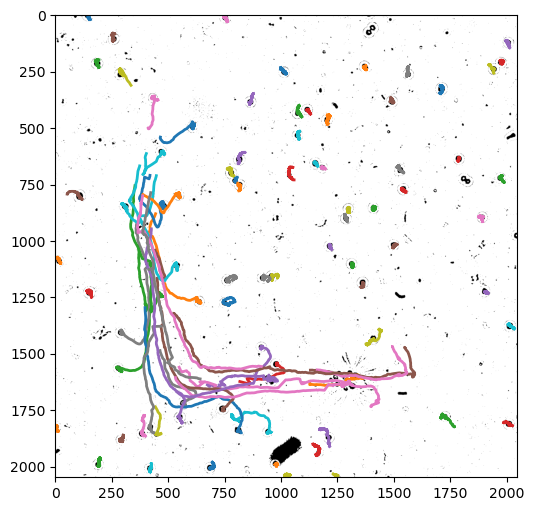

In [17]:
grouped = t1.groupby('particle')
plt.imshow(frames_thresh[100], cmap='gray')

for name, group in grouped:
    plt.plot(group['x'], group['y'], linewidth=2)

plt.show()

In [29]:
t1

y            x  frame  particle
frame                                           
0        18.708609   155.448124      0         0
0      1604.218845  1314.664134      0         2
0      1578.307305   294.929471      0         4
0      1549.622980   985.307002      0         5
0      1478.991597   911.523810      0         6
...            ...          ...    ...       ...
324     655.571174  1157.884342    324        89
324     632.895726  1790.526496    324        73
324     612.525773   403.432990    324        69
324     607.198098   841.161648    324        84
324     441.583333  1205.531250    324        49

[24954 rows x 4 columns]

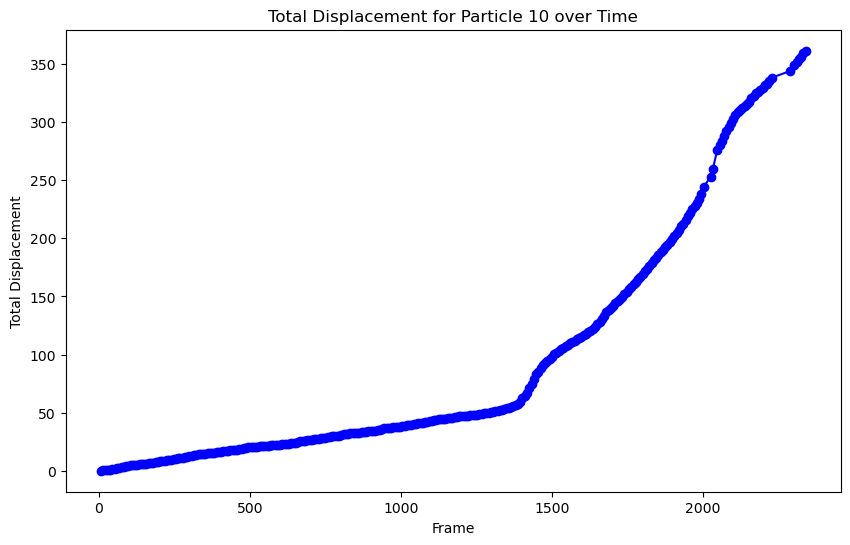

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def calculate_displacement(particles_df):
    """
    Add a 'total_displacement' column to a DataFrame of particle trajectories.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    # Check if 'frame' is identical to index. If yes, drop 'frame'. If not, rename 'frame'.
    if all(particles_df.index == particles_df['frame']):
        particles_df = particles_df.drop('frame', axis=1)
    else:
        particles_df = particles_df.rename(columns={'frame': 'frame_col'})

    particles_df['x_displacement'] = particles_df['x'].diff()
    particles_df['y_displacement'] = particles_df['y'].diff()
    
    # Calculate the total displacement for each frame
    particles_df['step_displacement'] = np.sqrt(particles_df['x_displacement']**2 + particles_df['y_displacement']**2)
    particles_df['total_displacement'] = particles_df['step_displacement'].cumsum()
    

    return particles_df





def remove_outliers(df, column_name):
    """
    Remove outliers in the specified column of the DataFrame using the IQR method.
    
    Parameters:
    df: DataFrame.
    column_name: Name of the column to remove outliers from.
    
    Returns:
    DataFrame with outliers removed.
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

def plot_particle_displacement(particles_df, particle_id):
    """
    Plot the displacement vs. time for a specific particle.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    particle_id: The ID of the particle to plot.
    """
    # Filter the DataFrame for the specified particle ID
    particle_trajectory = particles_df[particles_df['particle'] == particle_id].copy()

    # Calculate the displacement and remove outliers
    particle_trajectory = calculate_displacement(particle_trajectory)
    particle_trajectory = remove_outliers(particle_trajectory, 'total_displacement')

    # Plot the displacement vs. time for the particle
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(particle_trajectory['frame'], particle_trajectory['total_displacement'], marker='o', linestyle='-', color='b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Displacement (pixels)')
    ax.set_title(f'Displacement vs. Time (Particle {particle_id})')
    plt.show()

# Specify the particle ID to plot
particle_id = 10

displacement_df = calculate_displacement(t1[t1['particle']==10].copy())
# Plot the displacement vs. time for particle 105
#plot_particle_displacement(t1, particle_id)
# Reset the index of the dataframe
displacement_df.reset_index(level=0, inplace=True)

# Plot the displacement vs. time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(displacement_df['frame'] *60/8, displacement_df['total_displacement'] * 0.430, marker='o', linestyle='-', color='b')
ax.set_xlabel('Frame')
ax.set_ylabel('Total Displacement')
ax.set_title(f'Total Displacement for Particle {particle_id} over Time')
plt.show()


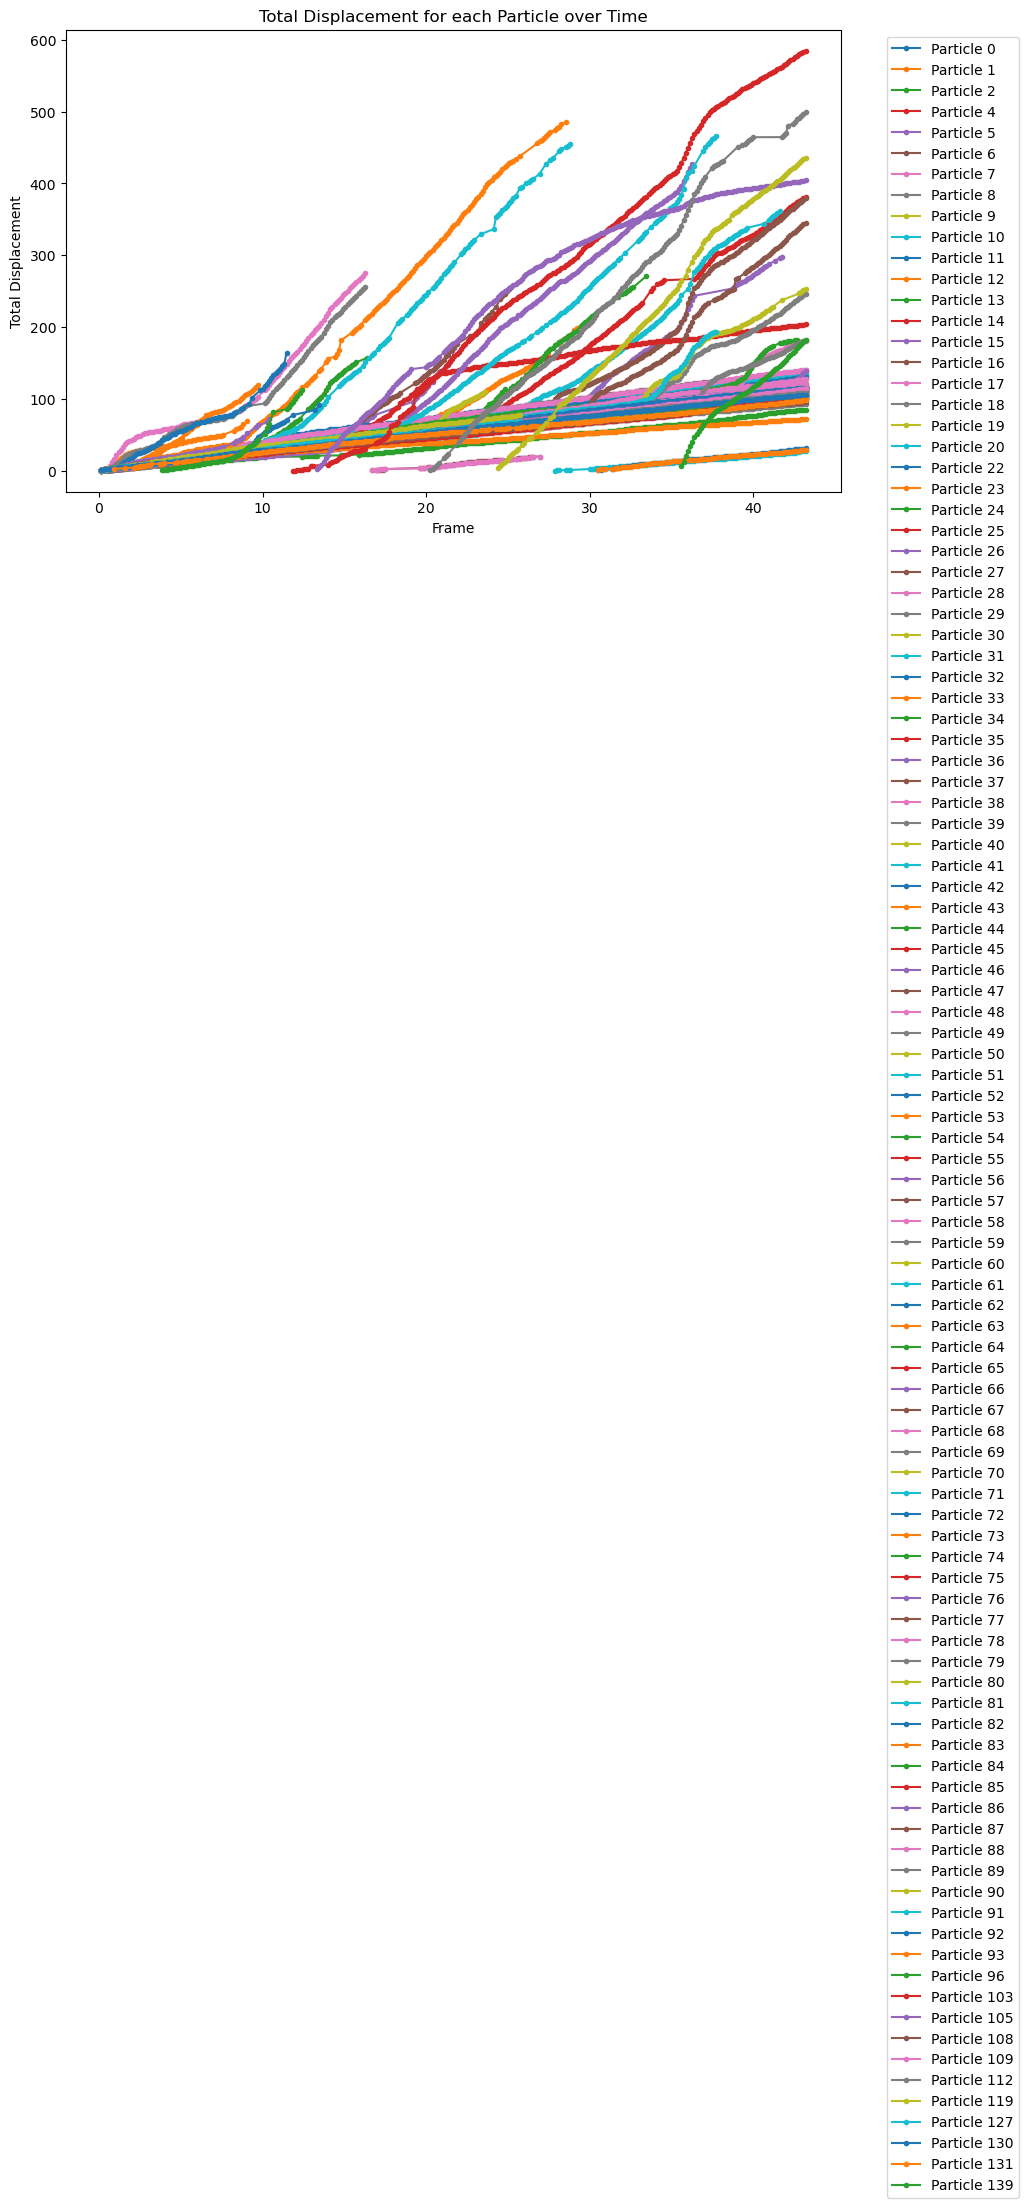

In [169]:
fig, ax = plt.subplots(figsize=(10, 6))

# Get all unique particle IDs
particle_ids = t1['particle'].unique()

# Loop over each particle ID
for particle_id in particle_ids:
    # Calculate displacement for this particle
    displacement_df = calculate_displacement(t1[t1['particle']==particle_id].copy())
    # Reset the index of the dataframe
    displacement_df.reset_index(level=0, inplace=True)
    # Plot the displacement vs. time
    ax.plot(displacement_df['frame'] * 8/60, displacement_df['total_displacement'] * 0.430, marker='.', linestyle='-', label=f'Particle {particle_id}')

ax.set_xlabel('Frame')
ax.set_ylabel('Total Displacement')
ax.set_title('Total Displacement for each Particle over Time')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()


In [145]:
def calculate_velocity(particles_df):
    """
    Calculate the velocity of particles from their displacements.
    
    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    # The time difference between frames (in seconds)
    dt = 8
    
    # Calculate the velocity between frames
    particles_df['velocity'] = particles_df['total_displacement'].diff() / dt
    
    return particles_df

velocity_df = calculate_velocity(displacement_df)
print(velocity_df.head())


   frame            y           x  particle  x_displacement  y_displacement  \
0    266  1215.689150  396.416422       139             NaN             NaN   
1    267  1201.751412  393.841808       139       -2.574614      -13.937737   
2    268  1186.853868  391.441261       139       -2.400547      -14.897544   
3    269  1170.080332  388.000000       139       -3.441261      -16.773536   
4    270  1153.822034  384.203390       139       -3.796610      -16.258299   

   step_displacement  total_displacement  velocity  
0                NaN                 NaN       NaN  
1          14.173537           14.173537       NaN  
2          15.089713           29.263251  1.886214  
3          17.122902           46.386153  2.140363  
4          16.695704           63.081856  2.086963  


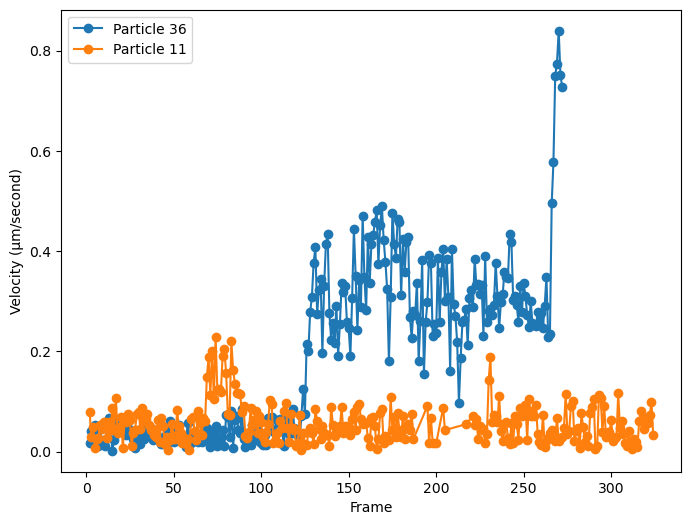

In [172]:
   
fig, ax = plt.subplots(figsize=(8, 6))

# Get all unique particle IDs
particle_ids = [36, 11]

# Loop over each particle ID
for particle_id in particle_ids:
    # Calculate displacement for this particle
    displacement_df = calculate_displacement(t1[t1['particle']==particle_id].copy())
    # Calculate velocity
    velocity_df = calculate_velocity(displacement_df)
    # Plot the velocity vs. time for the particle
    ax.plot(velocity_df.index, velocity_df['velocity']*0.43, marker='o', linestyle='-', label=f'Particle {particle_id}')

ax.set_xlabel('Frame')
ax.set_ylabel('Velocity (µm/second)')
ax.legend()
plt.show()



In [95]:
def calculate_all_displacements(particles_df):
    # Get the unique particle IDs
    unique_particles = particles_df['particle'].unique()

    # Create an empty DataFrame to store the results
    all_displacements_df = pd.DataFrame()

    # Loop over the unique particle IDs
    for particle_id in unique_particles:
        # Select the data for this particle
        particle_data = particles_df[particles_df['particle'] == particle_id].copy()

        # Calculate the displacement
        displacement_df = calculate_displacement(particle_data)

        # Append the results to the all_displacements_df DataFrame
        all_displacements_df = all_displacements_df.append(displacement_df)

    return all_displacements_df

# Call the function to calculate the displacement for all particles
all_displacements_df = calculate_all_displacements(t1)

# Now, all_displacements_df contains the displacement data for all particles


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/3872434503.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_displacements_df = all_displacements_df.append(displacement_df)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/3872434503.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_displacements_df = all_displacements_df.append(displacement_df)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/3872434503.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_displacements_df = all_displacements_df.append(displacement_df)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/3872434503.py:17: FutureWarning: The frame.append method is deprecated and wi

In [97]:
def calculate_velocity(df):
    # Since 'frame' is the index, we use diff() to calculate the difference between successive frames. 
    # We use abs() to ensure the velocity is always positive (it's a scalar quantity).
    df['velocity'] = df.groupby('particle')['total_displacement'].diff().abs() / df.index.to_series().diff().abs()

    return df

# Calculate velocity for each particle at each frame
velocity_df = calculate_velocity(all_displacements_df.copy())

# Drop the rows with NaN values - these are the first frame for each particle where velocity can't be calculated
velocity_df = velocity_df.dropna()

print(velocity_df)


                y           x  particle  x_displacement  y_displacement  \
frame                                                                     
2       19.612832  153.765487         0       -0.443604        0.360559   
3       19.189732  153.723214         0       -0.042272       -0.423100   
4       18.282222  153.086667         0       -0.636548       -0.907510   
5       18.590129  152.587983         0       -0.498684        0.307907   
6       18.337029  152.709534         0        0.121552       -0.253100   
...           ...         ...       ...             ...             ...   
320    833.809935  351.568035       139        1.331592       -8.398308   
321    827.012448  352.852697       139        1.284663       -6.797487   
322    821.183445  353.823266       139        0.970569       -5.829003   
323    814.172414  354.476293       139        0.653027       -7.011031   
324    807.214932  354.142534       139       -0.333759       -6.957482   

       step_displacement

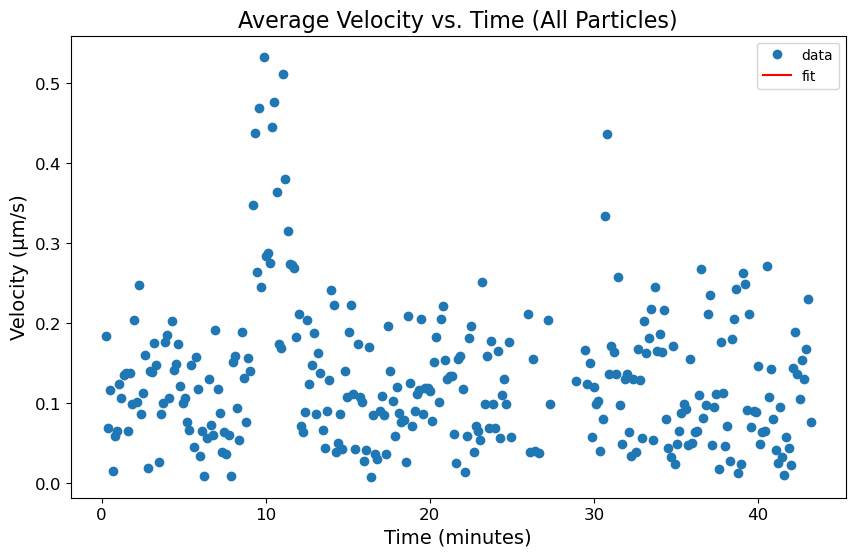

In [173]:
from scipy import stats

# Compute the mean velocity for each frame
mean_velocity = velocity_df.groupby(velocity_df.index)['velocity'].mean() 

# Compute the standard deviation of the velocity for each frame
std_velocity = velocity_df.groupby(velocity_df.index)['velocity'].std()

# Compute line fit
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_velocity.index, mean_velocity)

# Plot mean velocity over time with error bars representing the standard deviation
plt.figure(figsize=(10,6))
plt.plot(mean_velocity.index * 8 / 60, mean_velocity, marker='o', linestyle='', label='data')
plt.fill_between(mean_velocity.index * 8 / 60, (mean_velocity-std_velocity), (mean_velocity+std_velocity), color='b', alpha=.1)
plt.plot(mean_velocity.index * 8 / 60, intercept + slope*(mean_velocity.index), "r-", label='fit')

plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Velocity (µm/s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.title('Average Velocity vs. Time (All Particles)', fontsize=16)

plt.show()


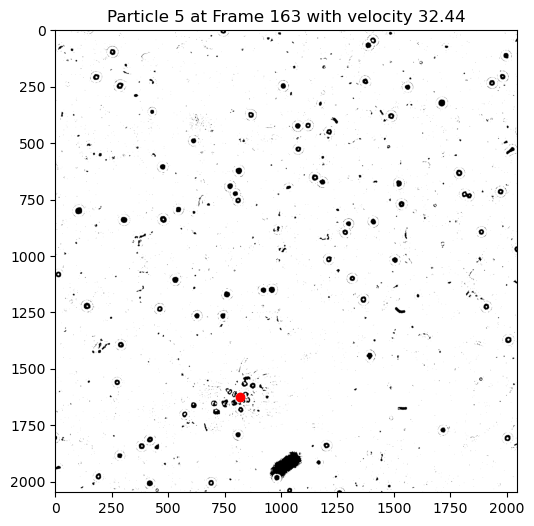

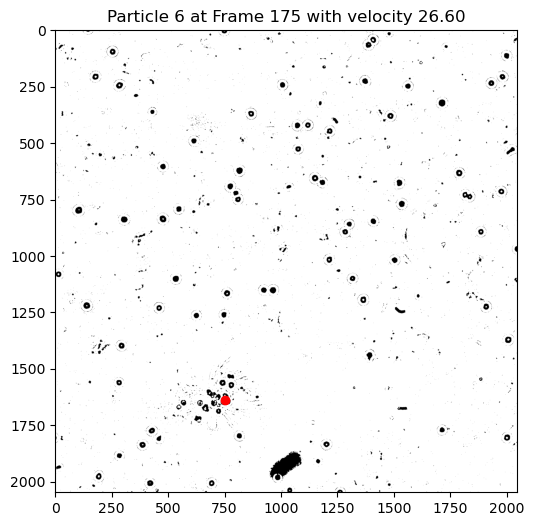

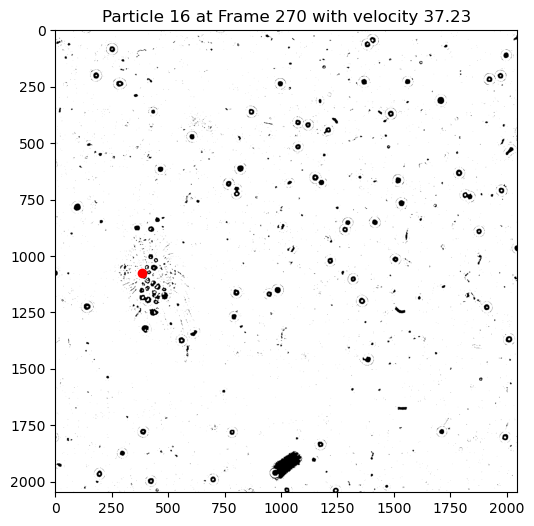

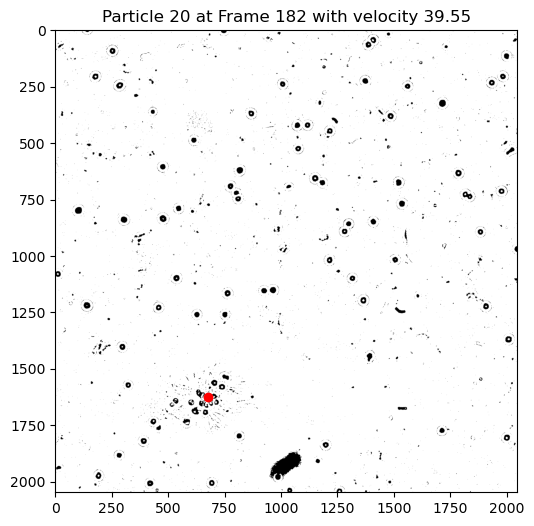

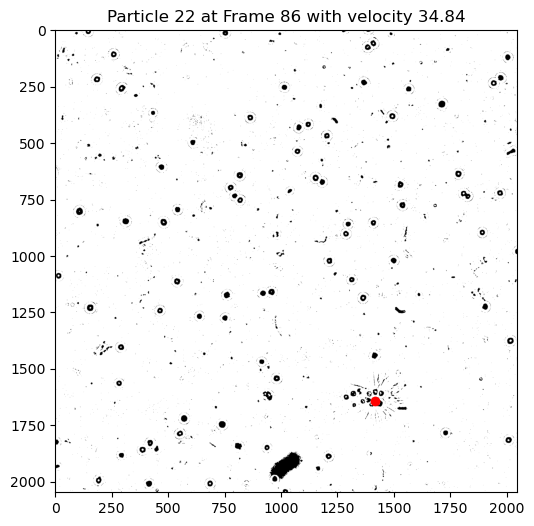

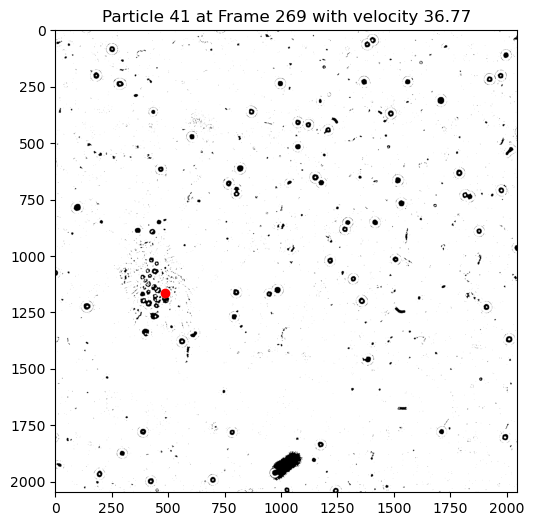

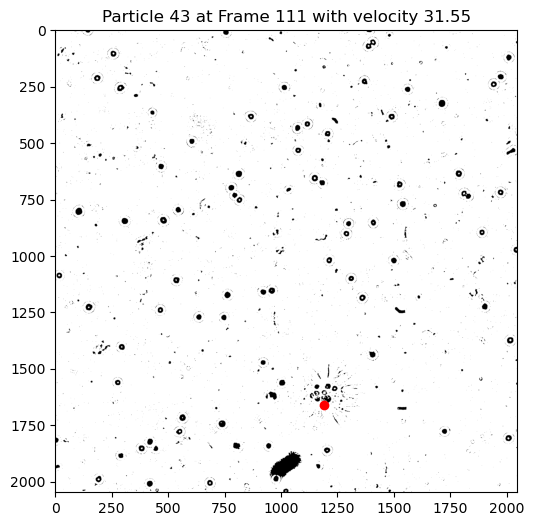

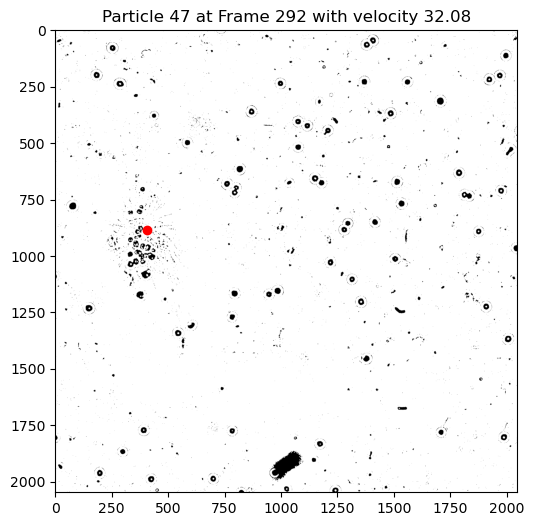

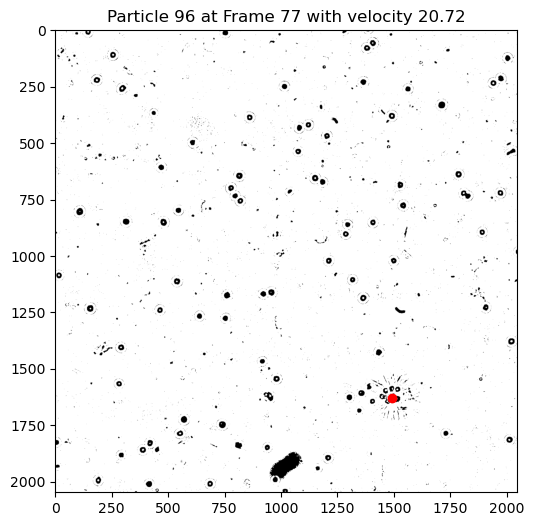

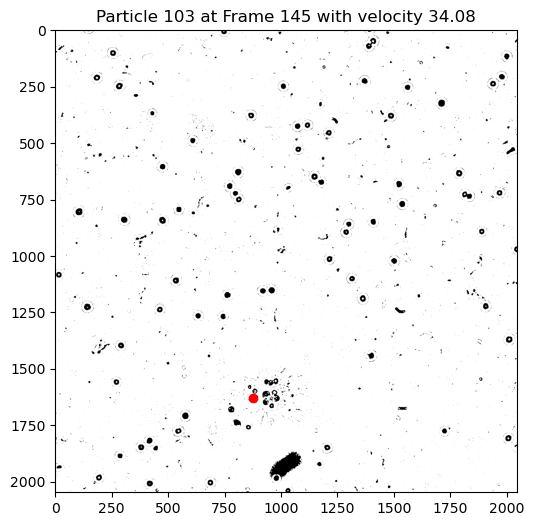

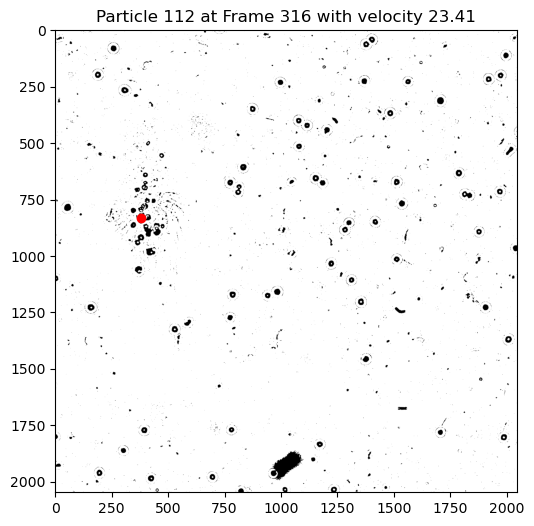

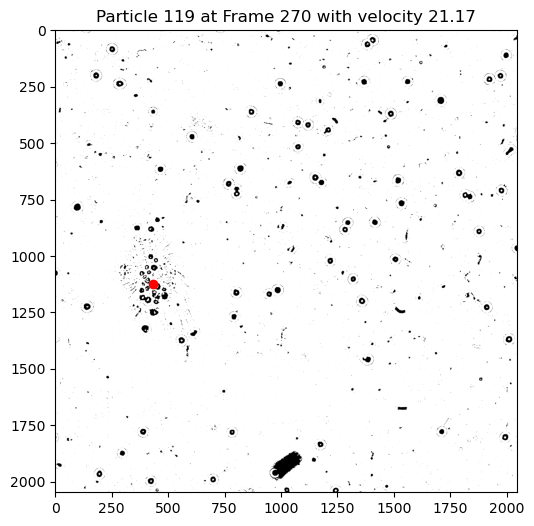

In [102]:
import matplotlib.pyplot as plt

# Filter the velocity dataframe for entries with velocity over 20
high_velocity_df = velocity_df[velocity_df['velocity'] > 20]

# Group the dataframe by particle ID
grouped_high_velocity = high_velocity_df.groupby('particle')

# For each high-velocity particle
for name, group in grouped_high_velocity:
    for i, row in group.iterrows():
        # Draw the corresponding frame
        plt.figure()  # create a new figure for each frame
        plt.imshow(frames_thresh[i], cmap='gray')  # using i instead of row['frame']

        # Highlight the high-velocity particle
        plt.scatter(row['x'], row['y'], color='red')
        plt.title(f'Particle {name} at Frame {i} with velocity {row["velocity"]:.2f}')
        
        # Save the figure if needed
        plt.savefig(f"high_velocity_particle_{name}_frame_{i}.png")

        plt.show()


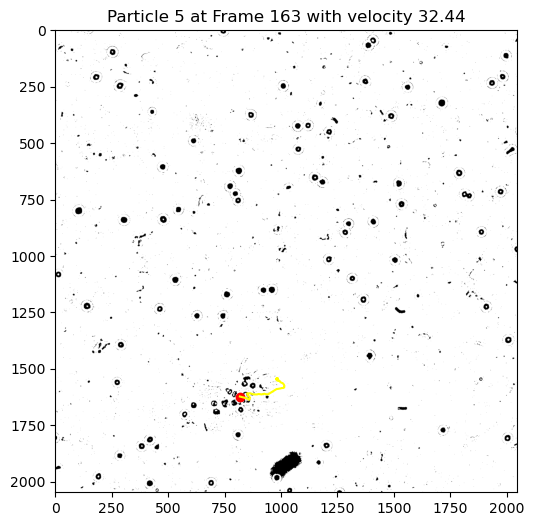

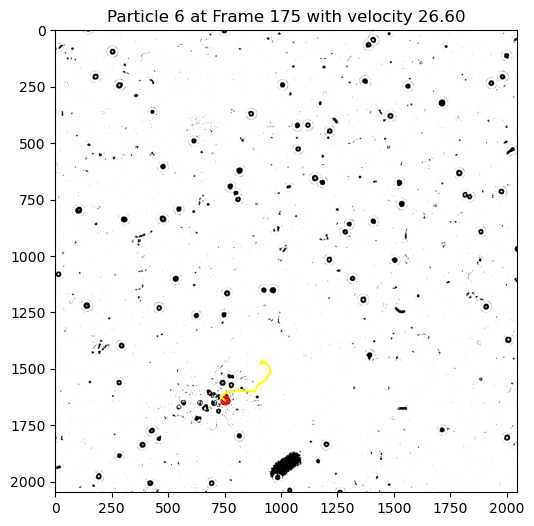

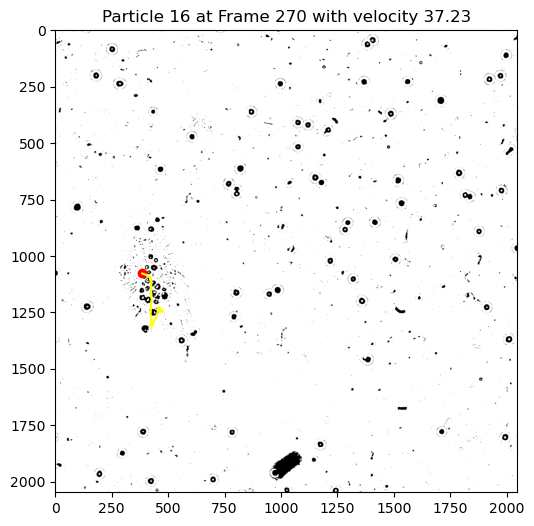

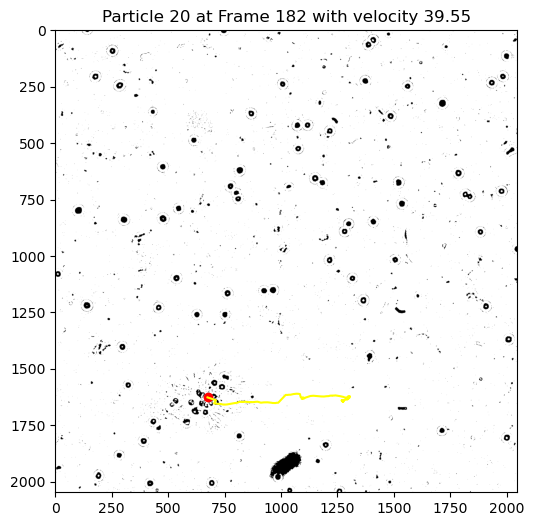

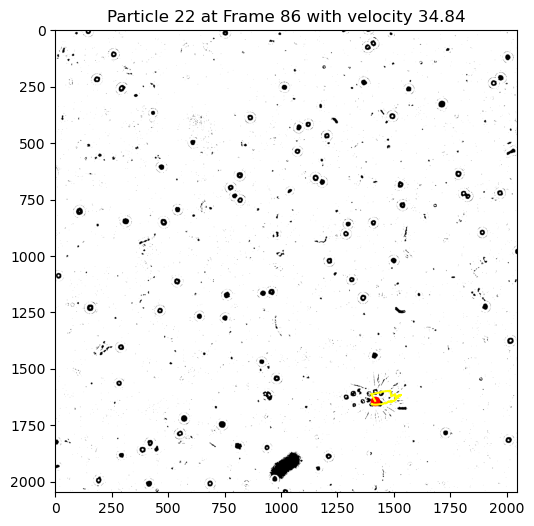

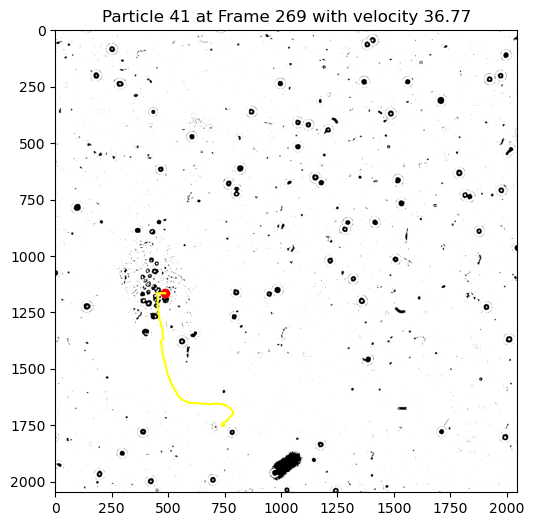

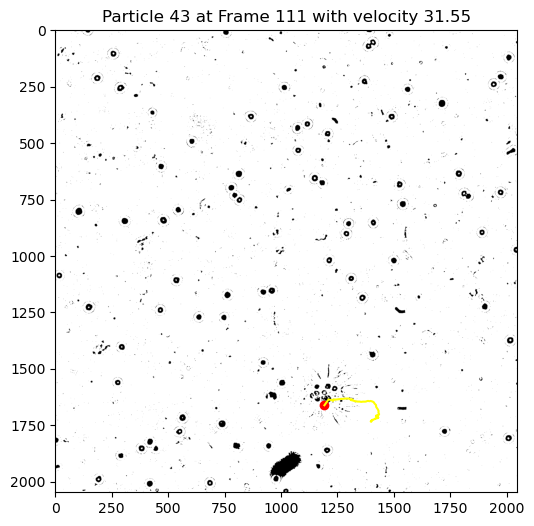

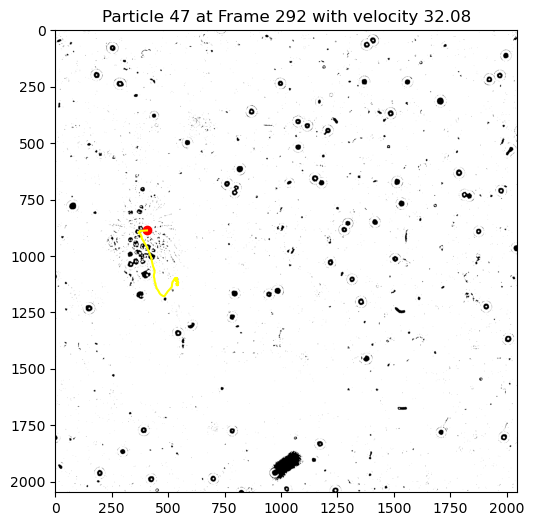

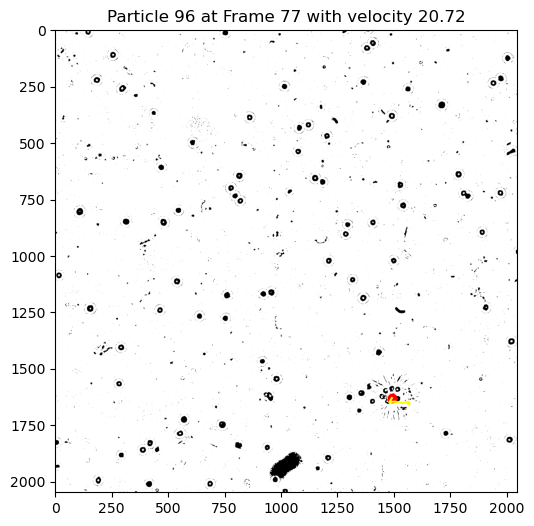

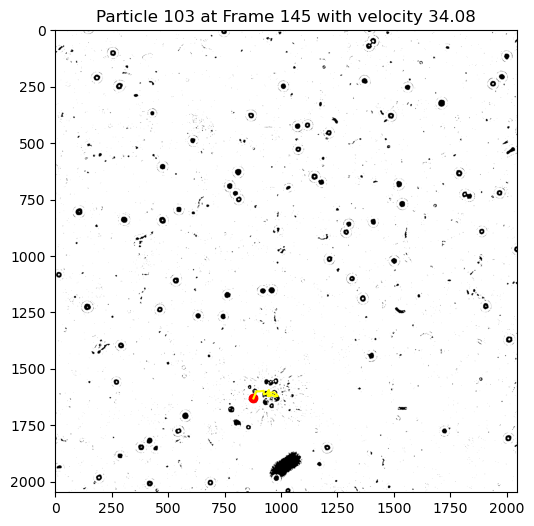

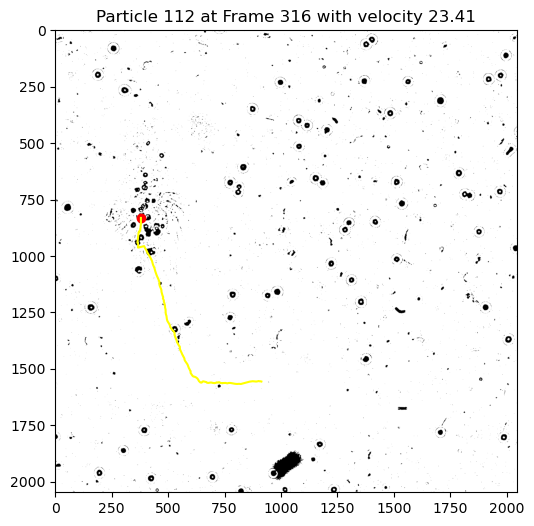

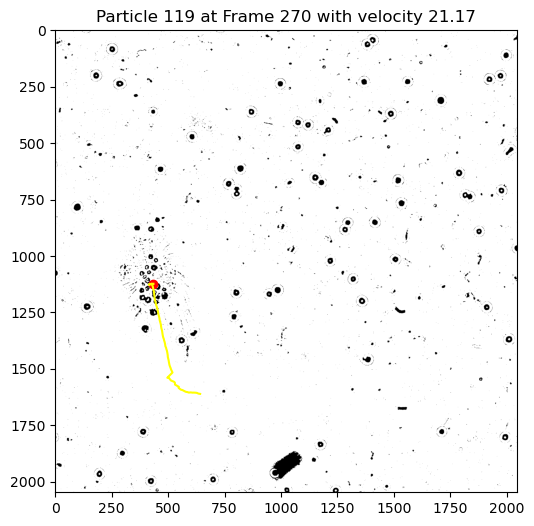

In [103]:
import matplotlib.pyplot as plt

# Filter the velocity dataframe for entries with velocity over 20
high_velocity_df = velocity_df[velocity_df['velocity'] > 20]

# Group the dataframe by particle ID
grouped_high_velocity = high_velocity_df.groupby('particle')

# For each high-velocity particle
for name, group in grouped_high_velocity:
    for i, row in group.iterrows():
        # Draw the corresponding frame
        plt.figure()  # create a new figure for each frame
        plt.imshow(frames_thresh[i], cmap='gray')  # using i instead of row['frame']

        # Get all positions of the particle until the current frame
        traj = t1.loc[(t1['particle'] == name) & (t1.index <= i)]

        # Plot the trajectory of the particle
        plt.plot(traj['x'], traj['y'], color='yellow')

        # Highlight the high-velocity particle
        plt.scatter(row['x'], row['y'], color='red')
        plt.title(f'Particle {name} at Frame {i} with velocity {row["velocity"]:.2f}')

        # Save the figure if needed
        plt.savefig(f"high_velocity_particle_{name}_frame_{i}.png")

        plt.show()


In [104]:
velocity_df

y           x  particle  x_displacement  y_displacement  \
frame                                                                     
2       19.612832  153.765487         0       -0.443604        0.360559   
3       19.189732  153.723214         0       -0.042272       -0.423100   
4       18.282222  153.086667         0       -0.636548       -0.907510   
5       18.590129  152.587983         0       -0.498684        0.307907   
6       18.337029  152.709534         0        0.121552       -0.253100   
...           ...         ...       ...             ...             ...   
320    833.809935  351.568035       139        1.331592       -8.398308   
321    827.012448  352.852697       139        1.284663       -6.797487   
322    821.183445  353.823266       139        0.970569       -5.829003   
323    814.172414  354.476293       139        0.653027       -7.011031   
324    807.214932  354.142534       139       -0.333759       -6.957482   

       step_displacement  total_displacement  velocity  
frame                                                   
2               0.571653            1.924714  0.571653  
3               0.425206            2.349920  0.425206  
4               1.108498            3.458418  1.108498  
5               0.586082            4.044499  0.586082  
6               0.280775            4.325274  0.280775  
...                  ...                 ...       ...  
320             8.503218          397.063911  8.503218  
321             6.917817          403.981728  6.917817  
322             5.909254          409.890982  5.909254  
323             7.041378          416.932360  7.041378  
324             6.965482          423.897843  6.965482  

[25797 rows x 8 columns]

## Now we calculate work

The Stokes' Law for the frictional force $F$ exerted on small spherical objects with a very small Reynolds number in a viscous fluid medium is given by:

$$ F = 6\pi\eta r v $$

where:
- $\eta$ is the dynamic viscosity of the fluid,
- $r$ is the radius of the spherical object,
- $v$ is the velocity of the particle.

In [155]:
# Define the constants
r = 6.5  # radius of the particle in micrometers, convert to meters
r = r * 1e-6
eta = 2 # viscosity of the fluid in Pa.s
pixel_to_meter = 0.430 * 1e-6  # Conversion factor from pixel to meter
frame_time_in_s = 1/8  # Time between frames in seconds

# Calculate the work done and add it as a new column in the dataframe
velocity_df['step_displacement_m'] = velocity_df['step_displacement'] * pixel_to_meter

velocity_df['velocity_m_per_s'] = velocity_df['velocity'] * pixel_to_meter / frame_time_in_s

velocity_df['work_done'] = 6 * np.pi * eta * r * velocity_df['velocity'] * velocity_df['step_displacement_m']


In [156]:
total_work_done = velocity_df['work_done'].sum()
total_work_done


6.239820269682243e-09

In [157]:
time_per_frame = 8

# Calculate the power for each row
velocity_df['power'] = velocity_df['work_done'] / time_per_frame


In [158]:
velocity_df

y            x  particle  x_displacement  y_displacement  \
frame                                                                       
0      1394.620079  1435.120079        11             NaN             NaN   
1      1394.089320  1434.462136        11       -0.657943       -0.530758   
2      1392.901961  1435.323529        11        0.861393       -1.187360   
3      1392.734496  1434.802326        11       -0.521204       -0.167465   
4      1391.809615  1434.857692        11        0.055367       -0.924881   
...            ...          ...       ...             ...             ...   
320    1457.548803  1379.254144        11       -1.065405       -0.612851   
321    1456.754647  1378.576208        11       -0.677935       -0.794156   
322    1455.425651  1378.399628        11       -0.176580       -1.328996   
323    1455.472998  1376.564246        11       -1.835382        0.047348   
324    1455.959108  1376.938662        11        0.374416        0.486110   

       step_displacement  total_displacement  velocity  step_displacement_m  \
frame                                                                         
0                    NaN                 NaN       NaN                  NaN   
1               0.845336            0.845336       NaN         3.634945e-07   
2               1.466909            2.312245  0.183364         6.307708e-07   
3               0.547447            2.859692  0.068431         2.354021e-07   
4               0.926536            3.786228  0.115817         3.984107e-07   
...                  ...                 ...       ...                  ...   
320             1.229095          306.353209  0.153637         5.285109e-07   
321             1.044165          307.397374  0.130521         4.489909e-07   
322             1.340676          308.738050  0.167584         5.764906e-07   
323             1.835993          310.574043  0.229499         7.894770e-07   
324             0.613588          311.187630  0.076698         2.638427e-07   

       velocity_m_per_s     work_done         power  
frame                                                
0                   NaN           NaN           NaN  
1                   NaN           NaN           NaN  
2          6.307708e-07  2.834192e-11  3.542739e-12  
3          2.354021e-07  3.947358e-12  4.934198e-13  
4          3.984107e-07  1.130702e-11  1.413377e-12  
...                 ...           ...           ...  
320        5.285109e-07  1.989729e-11  2.487161e-12  
321        4.489909e-07  1.436022e-11  1.795028e-12  
322        5.764906e-07  2.367394e-11  2.959242e-12  
323        7.894770e-07  4.439816e-11  5.549771e-12  
324        2.638427e-07  4.958796e-12  6.198495e-13  

[300 rows x 12 columns]

AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

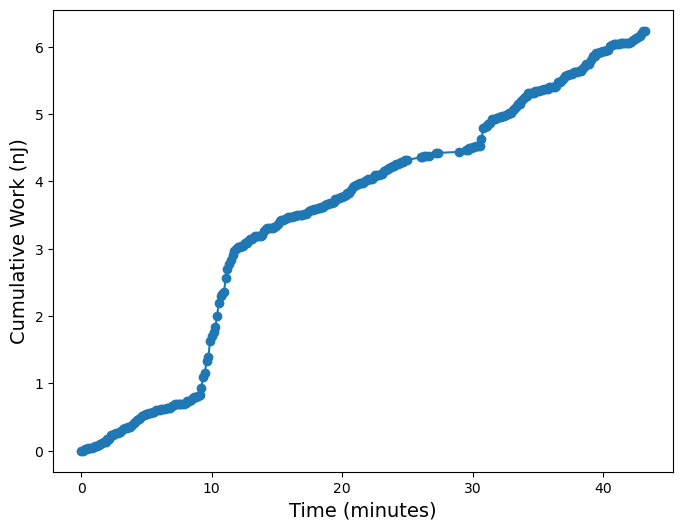

In [164]:
# Calculate the total work done at each time step
total_work = velocity_df.groupby(velocity_df.index)['work_done'].sum()

# Calculate the cumulative work
cumulative_work = total_work.cumsum()

# Plot the cumulative work vs. time
plt.figure(figsize=(8, 6))
plt.plot(cumulative_work.index * 8 / 60, cumulative_work * 1e9, marker='o', linestyle='-')
plt.xlabel('Time (minutes)', fontsize=14)
plt.ylabel('Cumulative Work (nJ)', fontsize=14)
#plt.title('Cumulative Work vs. Time (All Particles)')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.show()


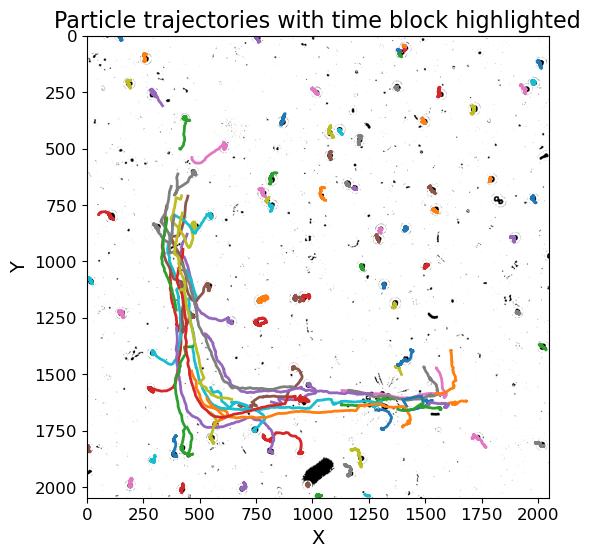

In [160]:
# Define the frames of interest
start_frame = 0
end_frame = 200

# Plot trajectories as before
grouped = t1.groupby('particle')

# Display the frame of interest
plt.figure(figsize=(10, 6))
plt.imshow(frames_thresh[100], cmap='gray')

for name, group in grouped:
    plt.plot(group['x'], group['y'], linewidth=2)

# Now add a transparent color block for frames of interest
plt.fill_between([start_frame, end_frame], 0, plt.ylim()[1], color='red', alpha=0.1)

plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.title('Particle trajectories with time block highlighted', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


In [153]:
# Calculate the total power at each time step 
total_power = velocity_df.groupby(velocity_df.index)['power'].sum()

# Calculate the cumulative power
cumulative_power = total_power.cumsum() * 1e9  # Convert to nW

# Plot the cumulative power vs. time
plt.figure(figsize=(10, 6))
plt.plot(cumulative_power.index * 8 / 60, cumulative_power, marker='o', linestyle='-')
plt.xlabel('Time (minutes)', fontsize=16)
plt.ylabel('Cumulative Power (nW)', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
plt.show()


KeyError: 'Column not found: power'

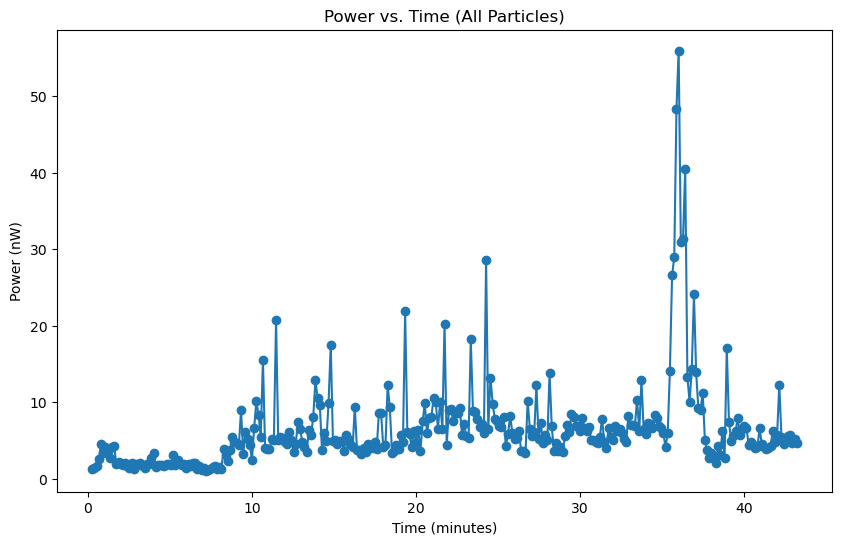

In [131]:
# Calculate the total power at each time step
total_power = velocity_df.groupby(velocity_df.index)['power'].sum()

# Plot the power vs. time
plt.figure(figsize=(10, 6))
plt.plot(total_power.index * 8 / 60, total_power * 1e9, marker='o', linestyle='-')
plt.xlabel('Time (minutes)')
plt.ylabel('Power (nW)')
plt.title('Power vs. Time (All Particles)')
plt.show()


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/561309460.py:14: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/561309460.py:16: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(16)


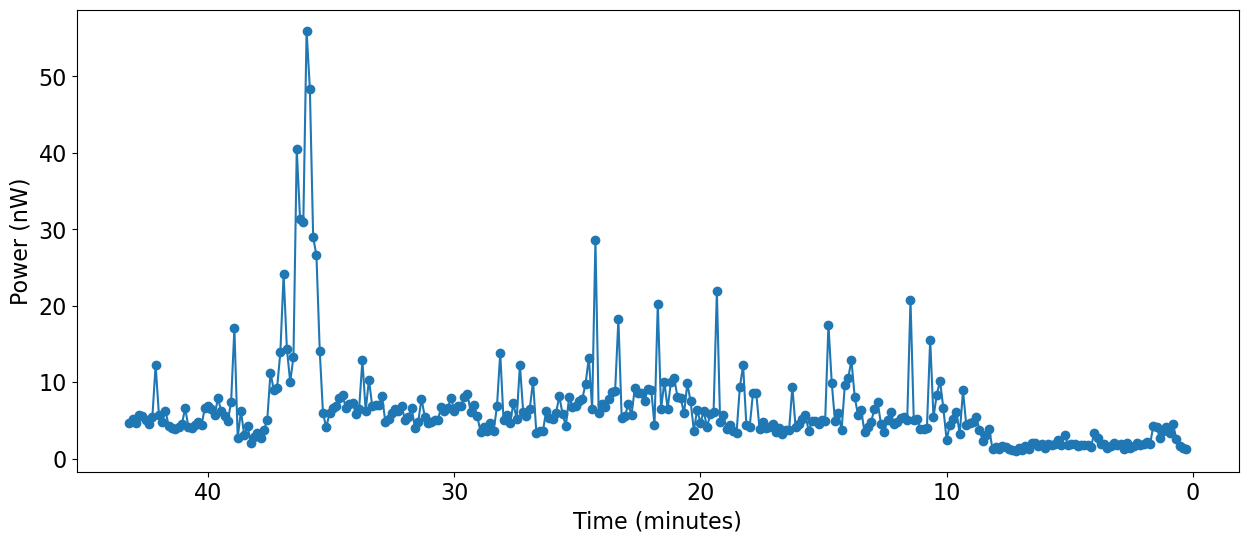

In [137]:
# Calculate the total power at each time step
total_power = velocity_df.groupby(velocity_df.index)['power'].sum()

# Plot the power vs. time
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(total_power.index * 8 / 60, total_power * 1e9, marker='o', linestyle='-')
ax.invert_xaxis()  # invert the x-axis

# Set the font size for the labels, title, and tick marks
ax.set_xlabel('Time (minutes)', fontsize=16)
ax.set_ylabel('Power (nW)', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

plt.show()


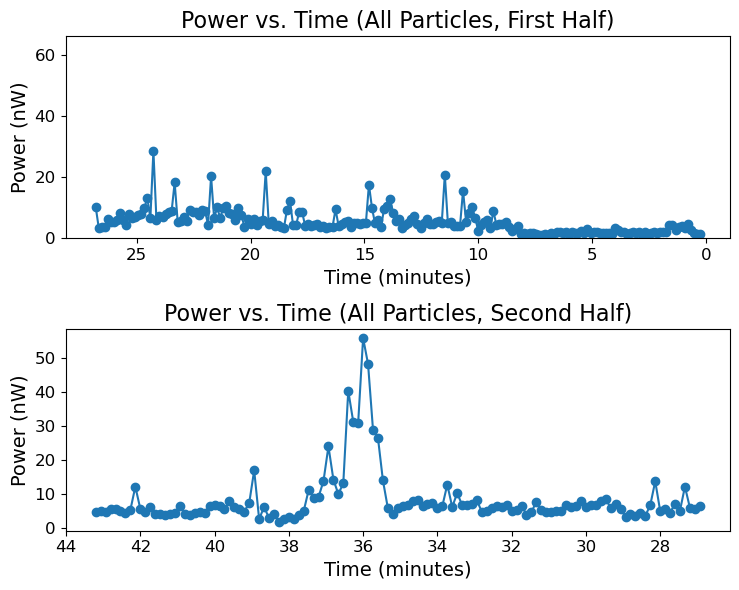

In [152]:
# Split your data into two parts
total_power_1 = total_power.iloc[:200]
total_power_2 = total_power.iloc[200:]
min_power = min(total_power.min(), total_power_2.min()) * 1e9
max_power = max(total_power.max(), total_power_2.max()) * 1e9

# Create a figure and an array of axes objects
fig, ax = plt.subplots(2, 1, figsize=(7.5, 6))

# Plot the first half of data
ax[0].plot(total_power_1.index * 8 / 60, total_power_1 * 1e9, marker='o', linestyle='-')
ax[0].set_xlabel('Time (minutes)', fontsize=14)
ax[0].set_ylabel('Power (nW)', fontsize=14)
ax[0].set_title('Power vs. Time (All Particles, First Half)', fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].invert_xaxis()
ax[0].set_ylim([0, max_power+10])


# Plot the second half of data
ax[1].plot(total_power_2.index * 8 / 60, total_power_2 * 1e9, marker='o', linestyle='-')
ax[1].set_xlabel('Time (minutes)', fontsize=14)
ax[1].set_ylabel('Power (nW)', fontsize=14)
ax[1].set_title('Power vs. Time (All Particles, Second Half)', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].invert_xaxis()
ax[0].set_ylim([0, max_power+10])


# Show the plot
plt.tight_layout()
plt.show()


In [135]:
high_power_frames = total_power[total_power > 15 / 1e9].index

print(high_power_frames)


Int64Index([80, 86, 111, 145, 163, 175, 182, 267, 268, 269, 270, 271, 272, 273,
            277, 292],
           dtype='int64', name='frame')


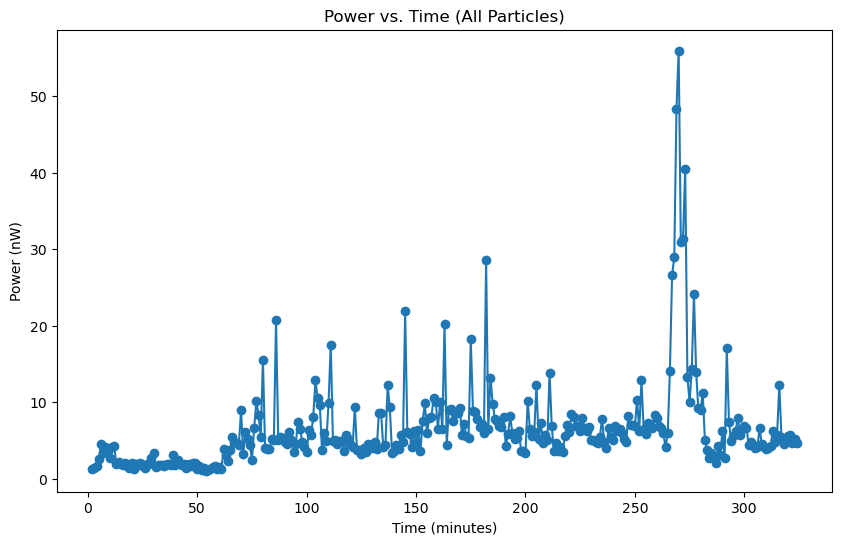

In [132]:
# Calculate the total power at each time step
total_power = velocity_df.groupby(velocity_df.index)['power'].sum()

# Plot the power vs. time
plt.figure(figsize=(10, 6))
plt.plot(total_power.index, total_power * 1e9, marker='o', linestyle='-')
plt.xlabel('Time (minutes)')
plt.ylabel('Power (nW)')
plt.title('Power vs. Time (All Particles)')
plt.show()


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/2791553338.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particle_work['cumulative_work'] = particle_work['work_done'].cumsum()
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/2791553338.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  particle_work['cumulative_work'] = particle_work['work_done'].cumsum()
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_32115/2791553338.py:13: SettingWithCopyWarning: 
A va

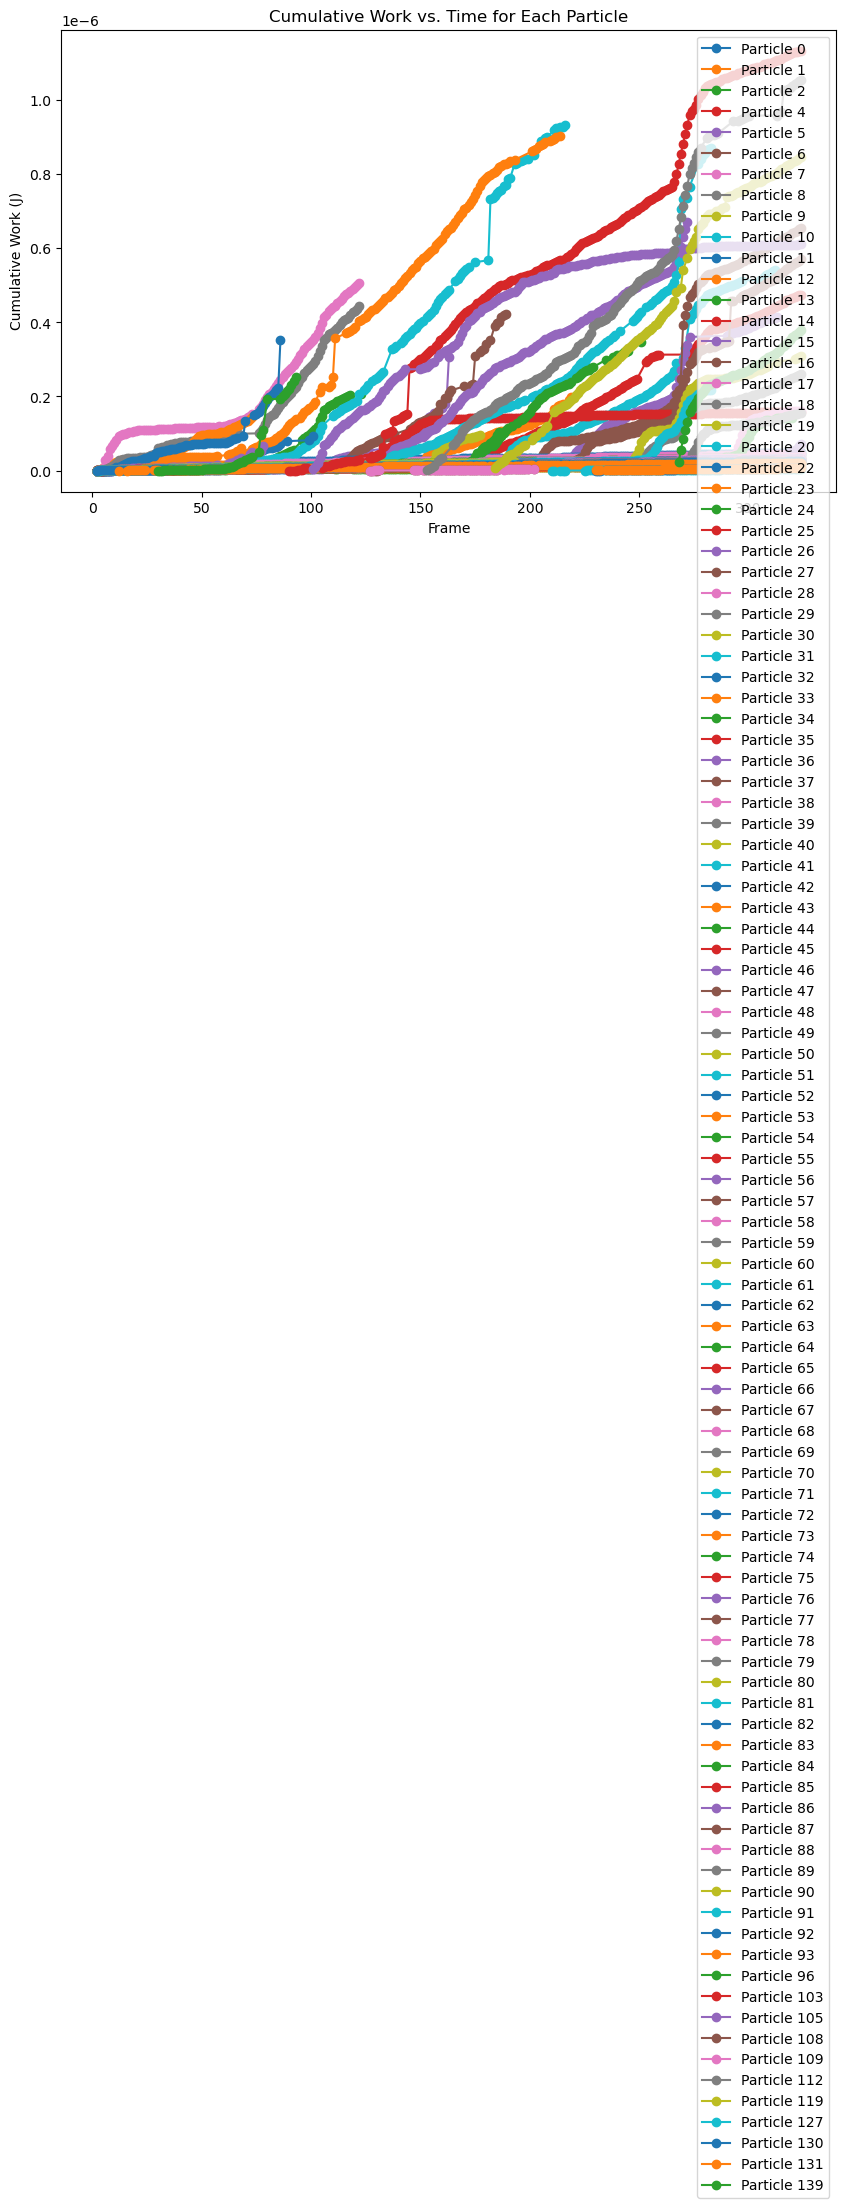

In [115]:
# Get the list of unique particle IDs
particle_ids = velocity_df['particle'].unique()

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over all particle IDs
for particle_id in particle_ids:
    # Filter the work DataFrame for the current particle ID
    particle_work = velocity_df[velocity_df['particle'] == particle_id]
    
    # Calculate the cumulative work for the current particle
    particle_work['cumulative_work'] = particle_work['work_done'].cumsum()

    # Plot the cumulative work versus time for the current particle
    plt.plot(particle_work.index, particle_work['cumulative_work'], marker='o', linestyle='-', label=f'Particle {particle_id}')

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Cumulative Work (J)')
plt.title('Cumulative Work vs. Time for Each Particle')

# Add a legend
plt.legend(loc='best')

# Show the plot
plt.show()


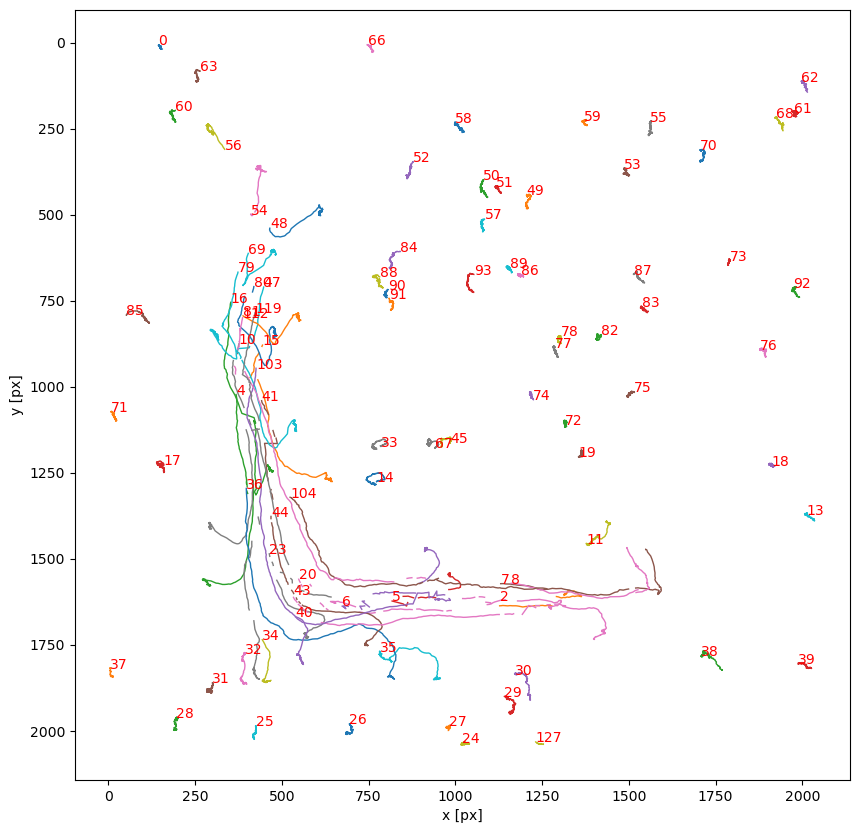

In [50]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t1)


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_22817/303666338.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(particle_df)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_22817/303666338.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(particle_df)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_22817/303666338.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(particle_df)
/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_22817/303666338.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

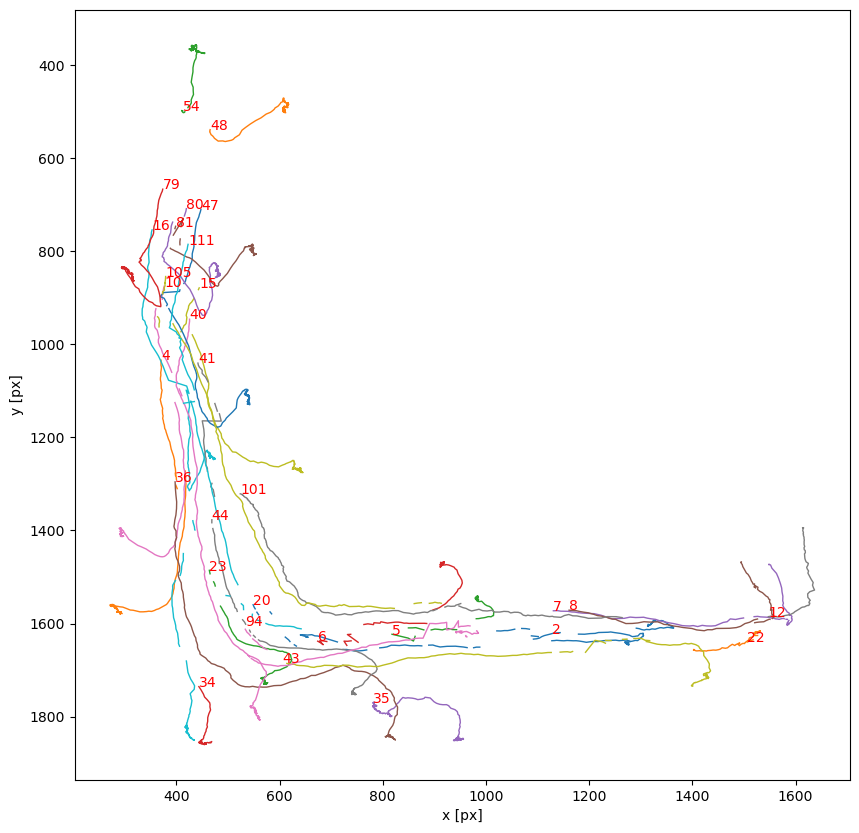

In [43]:
import math

# ...

def filter_short_trajectories(particles_df, max_distance):
    """
    Filter out particles that moved a maximum distance (in pixels) less than the specified value.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    max_distance: Maximum distance (in pixels) a particle should have moved to be included.

    Returns:
    filtered_df: Filtered DataFrame containing particles that moved a distance greater than max_distance.
    """
    filtered_df = pd.DataFrame(columns=particles_df.columns)
    
    for particle in particles_df['particle'].unique():
        particle_df = particles_df[particles_df['particle'] == particle]
        
        # Calculate the distance traveled by the particle
        dx = particle_df['x'].iloc[-1] - particle_df['x'].iloc[0]
        dy = particle_df['y'].iloc[-1] - particle_df['y'].iloc[0]
        distance = math.sqrt(dx**2 + dy**2)
        
        # Check if the distance is greater than max_distance
        if distance > max_distance:
            filtered_df = filtered_df.append(particle_df)
    
    return filtered_df

# ...

# After tp.filter_stubs(t1, threshold=66), filter short trajectories
max_distance = 100  # Maximum distance in pixels
t2 = filter_short_trajectories(t1, max_distance)

# Plot the filtered trajectories
plot_trajectory_with_labels(t2)


In [88]:
t2

y            x frame particle        dx        dy   dt  \
0    1604.218845  1314.664134     0        2       NaN       NaN  NaN   
1    1605.169697  1314.742424     1        2  0.078291  0.950852  1.0   
2    1604.597285  1313.876320     2        2 -0.866104 -0.572412  1.0   
3    1605.328197  1314.169492     3        2  0.293172  0.730912  1.0   
4    1605.384025  1314.377880     4        2  0.208389  0.055827  1.0   
..           ...          ...   ...      ...       ...       ...  ...   
320   808.139908   416.511468   320      111  1.325064 -5.759215  1.0   
321   801.896104   418.562771   321      111  2.051303 -6.243804  1.0   
322   797.006536   421.002179   322      111  2.439408 -4.889568  1.0   
323   790.938429   421.811040   323      111  0.808862 -6.068107  1.0   
324   785.671488   422.801653   324      111  0.990613 -5.266941  1.0   

     velocity  total_displacement  total_distance_um  
0         NaN                 NaN                NaN  
1    0.954070            0.954070           0.410250  
2    1.038168            1.992237           1.266912  
3    0.787517            2.779754           2.462206  
4    0.215737            2.995491           3.750267  
..        ...                 ...                ...  
320  5.909683          909.026518       26555.933329  
321  6.572133          915.598651       26949.640749  
322  5.464301          921.062952       27345.697819  
323  6.121779          927.184731       27744.387253  
324  5.359289          932.544021       28145.381182  

[6717 rows x 10 columns]

KeyError: 'total_displacement'

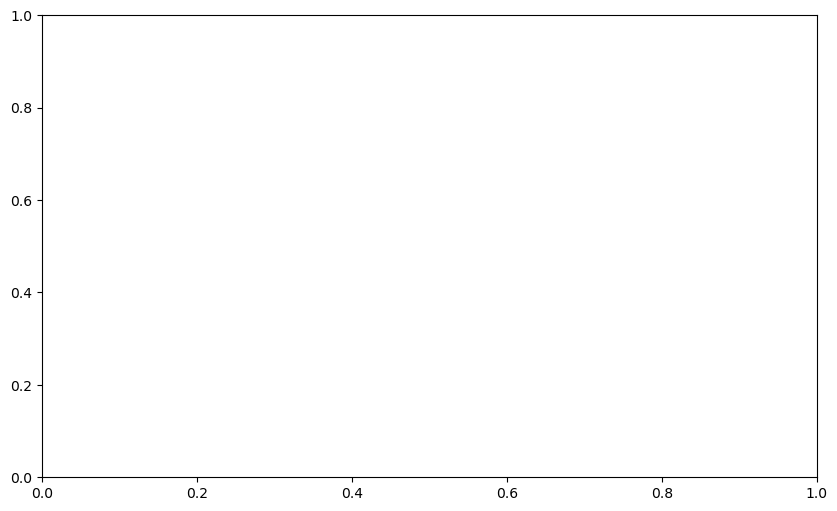

In [30]:
def plot_particle_displacement(particles_df, particle_id):
    """
    Plot the displacement vs. time for a specific particle.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    particle_id: The ID of the particle to plot.
    """
    # Filter the DataFrame for the specified particle ID
    particle_trajectory = particles_df[particles_df['particle'] == particle_id]

    # Plot the displacement vs. time for the particle
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(particle_trajectory['frame'], particle_trajectory['total_displacement'], marker='o', linestyle='-', color='b')
    ax.set_xlabel('Frame')
    ax.set_ylabel('Displacement (pixels)')
    ax.set_title(f'Displacement vs. Time (Particle {particle_id})')
    plt.show()

# Specify the particle ID to plot
particle_id = 60

# Plot the displacement vs. time for particle 105
plot_particle_displacement(t1, particle_id)


In [87]:
def print_particle_displacement(particles_df, particle_id):
    """
    Print the displacement values for a specific particle.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    particle_id: The ID of the particle to print.
    """
    # Filter the DataFrame for the specified particle ID
    particle_trajectory = particles_df[particles_df['particle'] == particle_id]

    # Print the displacement values
    displacement_values = particle_trajectory['total_displacement']
    print(f"Displacement of Particle {particle_id}:")
    for frame, displacement in zip(particle_trajectory['frame'], displacement_values):
        print(f"Frame {frame}: {displacement} pixels")

# Specify the particle ID
particle_id = 105

# Print the displacement of particle 105
print_particle_displacement(t2, particle_id)


Displacement of Particle 105:
Frame 151: nan pixels
Frame 152: 3.3406460103542077 pixels
Frame 153: 6.156843097101433 pixels
Frame 154: 12.64286590756303 pixels
Frame 155: 16.855280905874288 pixels
Frame 156: 23.721990662974584 pixels
Frame 158: 62.98763043784746 pixels
Frame 159: 39.319251056918304 pixels
Frame 160: 45.497600313916955 pixels
Frame 165: 267.3575696351402 pixels
Frame 166: 61.32900554765772 pixels
Frame 167: 70.53190841783058 pixels
Frame 168: 79.07815694023716 pixels
Frame 169: 89.3723252757353 pixels
Frame 170: 99.04620957172094 pixels
Frame 171: 106.46647141454085 pixels
Frame 172: 114.35933221881291 pixels
Frame 173: 122.55050953355058 pixels
Frame 174: 127.84124068746125 pixels
Frame 175: 134.36176034723934 pixels
Frame 176: 141.54899025397017 pixels
Frame 177: 148.2648690697578 pixels
Frame 178: 152.7559058078514 pixels
Frame 179: 157.7249918403908 pixels
Frame 180: 162.56372331420127 pixels
Frame 181: 166.7259396435059 pixels
Frame 182: 173.04057892245362 pixels


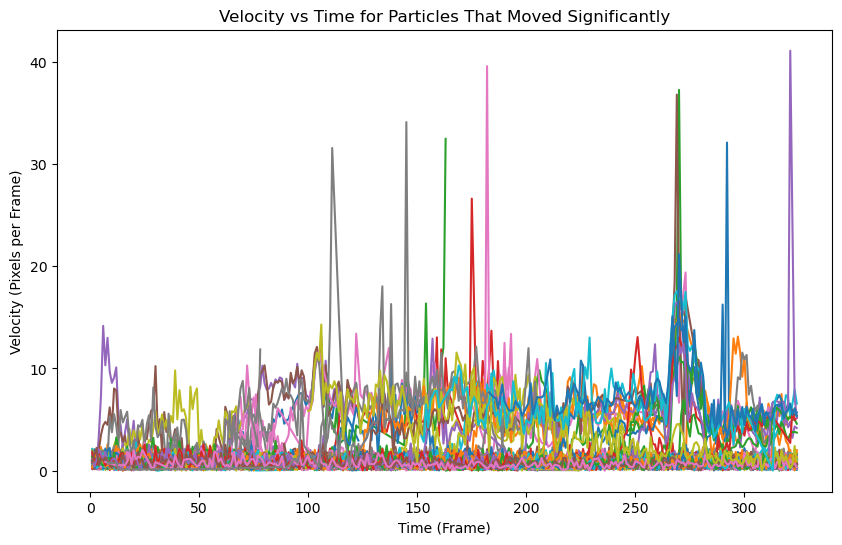

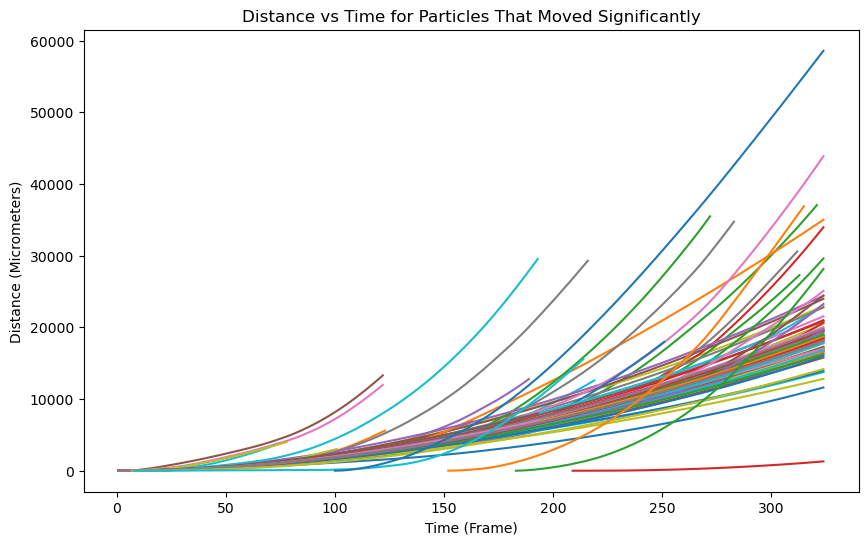

In [35]:
# Calculate the total distance traveled by each particle
t1['total_displacement'] = t1.groupby('particle')['velocity'].cumsum() * t1['dt']

# Identify particles that moved significantly (total distance travelled more than 100 pixels)
significant_particles = t1.groupby('particle').filter(lambda x: np.max(x['total_displacement']) > 100)

if not significant_particles.empty:
    # Group the significant particles
    grouped = significant_particles.groupby('particle')

    # Plot velocity vs time for each particle
    plt.figure()
    for name, group in grouped:
        plt.plot(group['frame'], group['velocity'], label=f'Particle {name}')

    plt.xlabel('Time (Frame)')
    plt.ylabel('Velocity (Pixels per Frame)')
    plt.title('Velocity vs Time for Particles That Moved Significantly')
    plt.show()
else:
    print("No particles travelled more than 100 pixels.")

# Calculate the total distance traveled by each particle in micrometers
t1['total_distance_um'] = t1.groupby('particle')['total_displacement'].cumsum() * 0.430  # Assuming each pixel is 0.430 micrometers

# Identify particles that moved significantly (total distance travelled more than 100 micrometers)
significant_particles_distance = t1.groupby('particle').filter(lambda x: np.max(x['total_distance_um']) > 100)

if not significant_particles_distance.empty:
    # Group the significant particles by particle
    grouped_distance = significant_particles_distance.groupby('particle')

    # Plot distance vs time for each significantly moving particle
    plt.figure()
    for name, group in grouped_distance:
        # Ensure distance does not decrease
        distance = group['total_distance_um'].copy()
        distance[distance < distance.shift()] = distance.shift()
        plt.plot(group['frame'], distance, label=f'Particle {name}')

    plt.xlabel('Time (Frame)')
    plt.ylabel('Distance (Micrometers)')
    plt.title('Distance vs Time for Particles That Moved Significantly')
    plt.show()
else:
    print("No particles travelled more than 100 micrometers.")


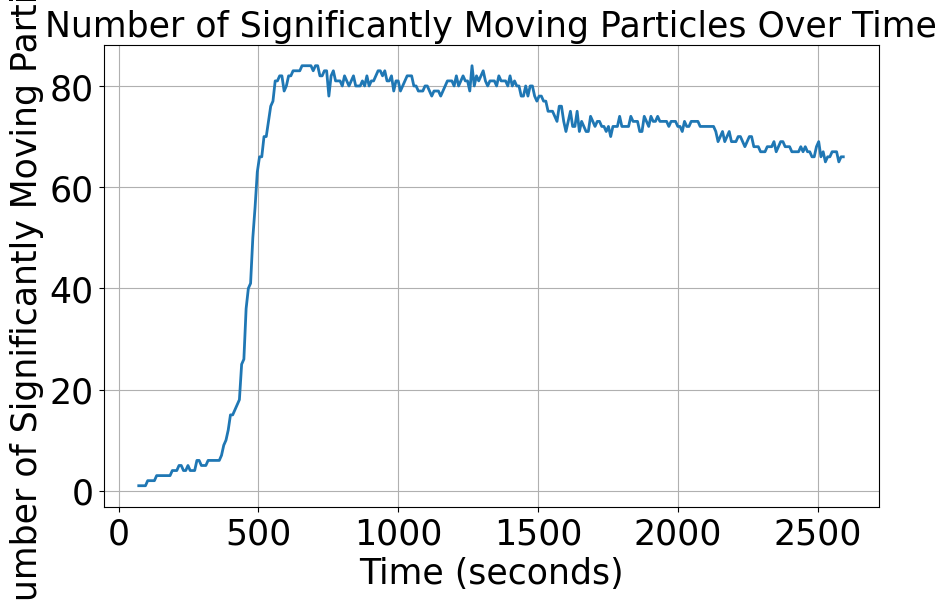

In [34]:
# Convert frame to time in seconds
significant_movers_per_frame.index *= 8

# Plot the number of particles that moved significantly in each frame over time
plt.figure(figsize=(10,6))
plt.plot(significant_movers_per_frame.index, significant_movers_per_frame.values, linewidth=2)
plt.xlabel('Time (seconds)', fontsize=25)
plt.ylabel('Number of Significantly Moving Particles', fontsize=25)
plt.title('Number of Significantly Moving Particles Over Time', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid(True)
plt.show()


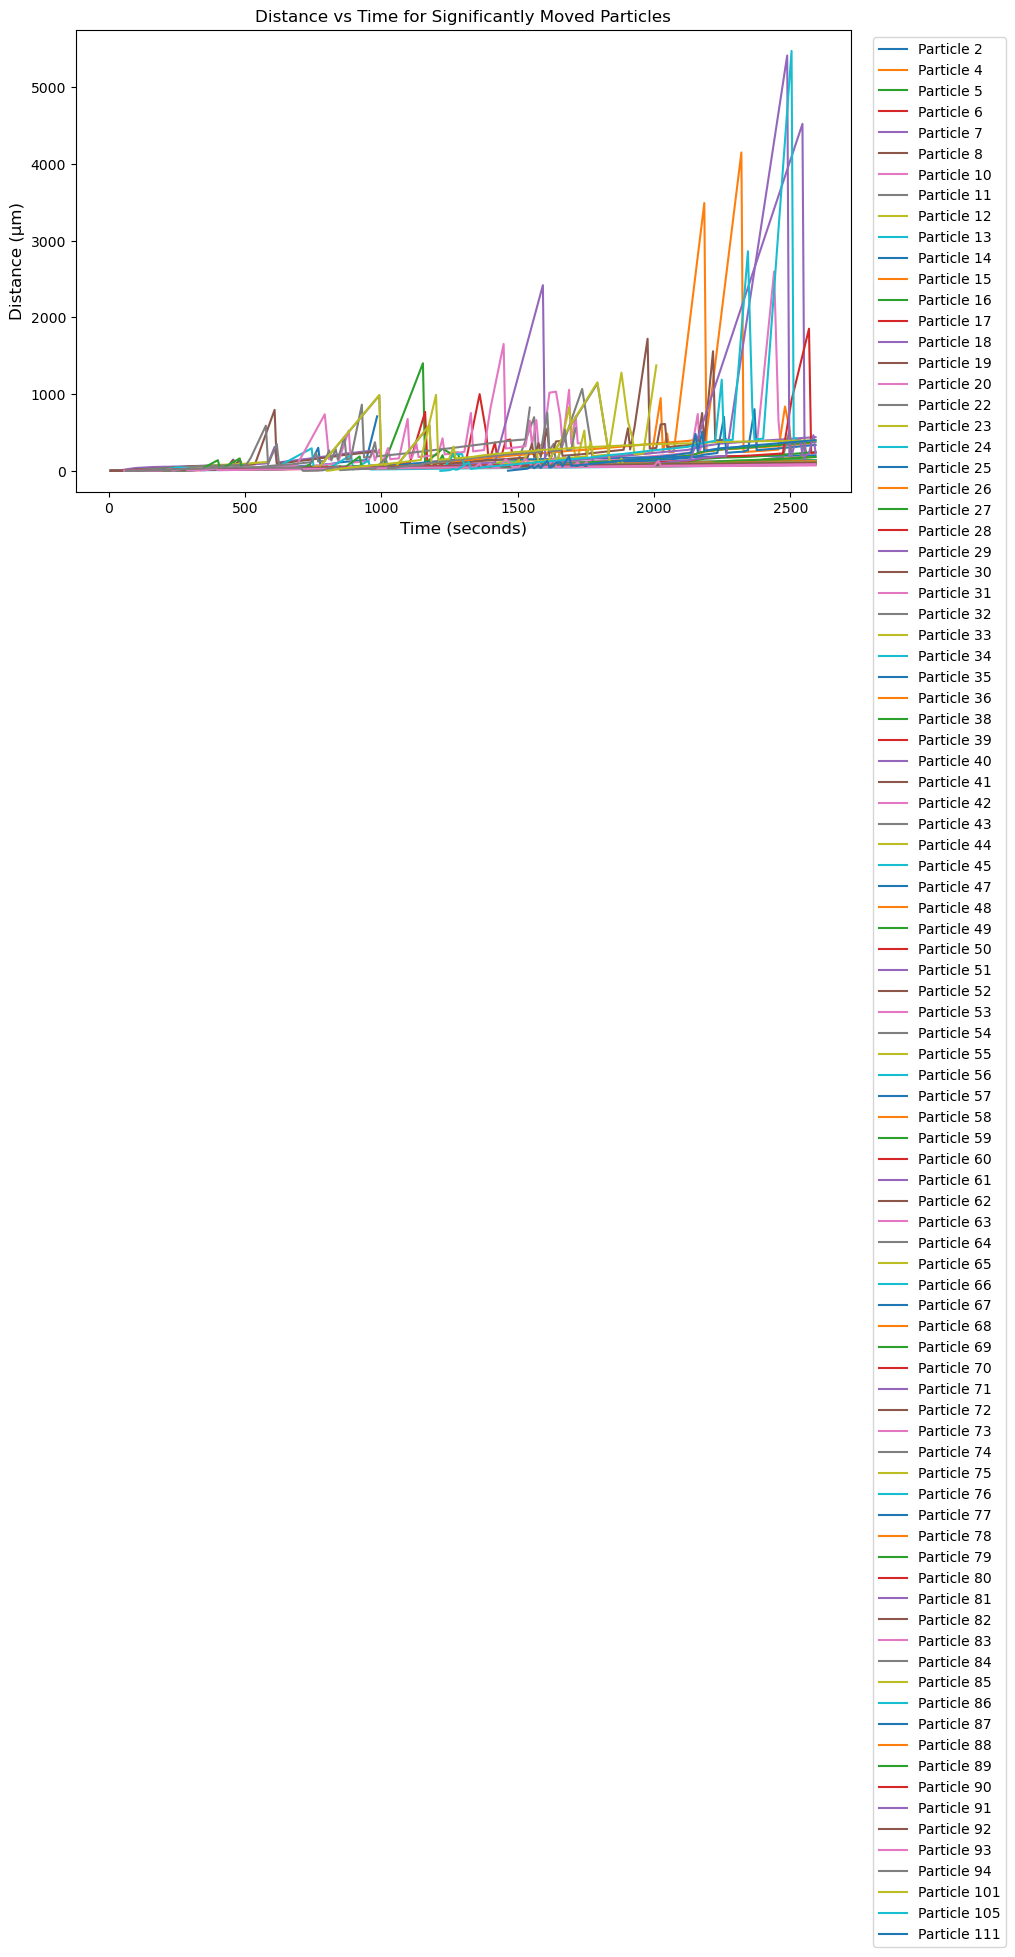

In [31]:
# Define a function to plot distance vs time for each particle
def plot_distance_vs_time(particle_data):
    # Convert frame number to time in seconds
    time = particle_data['frame'] * 8  # replace 8 with your actual frame time in seconds

    # Convert distance to micrometers
    particle_data['distance_um'] = particle_data['total_displacement'] * 0.4300668  # replace with your actual conversion factor

    # Plot total distance traveled for this particle
    plt.plot(time, particle_data['distance_um'], label=f'Particle {particle_data.name}')

# Group significant_particles by particle
grouped = significant_particles.groupby('particle')

plt.figure()

# Plot distance vs time for each significantly moved particle
grouped.apply(plot_distance_vs_time)

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Distance (µm)', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title('Distance vs Time for Significantly Moved Particles')
plt.show()


In [28]:
# Sort the dataframe by particle and frame number
df_sorted = t1.sort_values(['particle', 'frame'])

# Calculate distance traveled for each particle
df_sorted['distance'] = np.sqrt((df_sorted['x'].diff())**2 + (df_sorted['y'].diff())**2)
df_sorted['distance'] = df_sorted.groupby('particle')['distance'].cumsum()

# Adjust distance for particle 24 to start from 0
df_sorted.loc[df_sorted['particle'] == 24, 'distance'] -= df_sorted.loc[df_sorted['particle'] == 24, 'distance'].iloc[0]

# Convert distance to micrometers
df_sorted['distance'] *= 0.4300668

# Filter dataframe for particles 20 and 24 and up to frame 69
particle_20 = df_sorted[(df_sorted['particle'] == 20) & (df_sorted['frame'] <= 69)]
particle_24 = df_sorted[(df_sorted['particle'] == 24) & (df_sorted['frame'] <= 69)]

# Convert frame number to time in seconds
time_20 = particle_20['frame'] * 8
time_24 = particle_24['frame'] * 8

# Plot total distance traveled for particle 20
plt.plot(time_20, particle_20['distance'], label='Particle 20')

# Plot total distance traveled for particle 24
plt.plot(time_24, particle_24['distance'], label='Particle 24')

plt.xlabel('Time (seconds)', fontsize=30)
plt.ylabel('Distance (µm)', fontsize=30)
plt.legend(fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


ValueError: 'frame' is both an index level and a column label, which is ambiguous.

In [14]:
def plot_and_save_trajectory(frame_num, t, frames, save_path, dpi=300, linewidth=2):
    # Create a figure and axes
    fig, ax = plt.subplots()
    
    # Display the frame
    ax.imshow(frames[frame_num], cmap='gray')

    # Select the trajectories up to the current frame
    t_current = t.loc[t['frame'] <= frame_num]

    # Group the trajectories by particle ID
    grouped = t_current.groupby('particle')

    # Plot each trajectory with the specified linewidth
    for name, group in grouped:
        ax.plot(group['x'], group['y'], linewidth=linewidth)

    # Remove axes
    ax.axis('off')

    # Save the figure
    fig.savefig(save_path.format(frame_num), dpi=dpi, bbox_inches='tight')
    
    # Close the figure
    plt.close(fig)





In [15]:
save_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/local to global pre-print/manuscript and figures/figure_4/image_slices/cell_eater_traj/frame_{}.png'
num_frames = len(frames_thresh)

for i in range(num_frames):
    plot_and_save_trajectory(i, t1, video, save_path)